Este colab fue adaptado por Arnold Charry y Valeria Palacio.

# Irregular Cutting Stock Problem (ICSP)


In [2]:
polys = []

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from scipy.interpolate import splprep, splev
from scipy.spatial import ConvexHull
from shapely.geometry import Point,mapping,LineString
from shapely.ops import unary_union
from shapely import affinity
import pyclipper
import math
import pandas as pd
import json
import csv
import time
import logging
import random
import copy
import os
import multiprocessing
import datetime

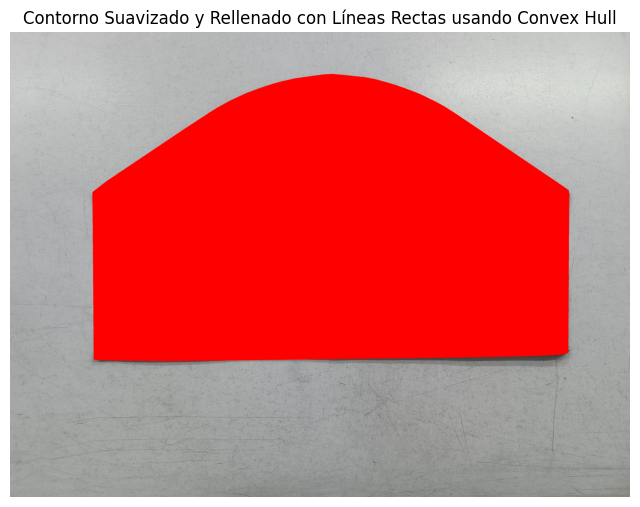

In [4]:
# Función para suavizar los contornos utilizando B-splines
def suavizar_contorno(contorno, s=0.001):
    contorno = contorno[:, 0, :]  # quitar una dimensión innecesaria
    x, y = contorno[:, 0], contorno[:, 1]
    tck, u = splprep([x, y], s=s)
    u_fine = np.linspace(0, 1, 1000)
    x_fine, y_fine = splev(u_fine, tck)
    return np.vstack((x_fine, y_fine)).T

# Cargar la imagen
imagen = cv2.imread('inputs/Manga corta.jpg')

# Obtener las dimensiones de la imagen
alto, ancho, _ = imagen.shape

# Calcular el número total de píxeles en la imagen
pixeles_totales = alto * ancho

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro gaussiano para suavizar la imagen
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar un umbral adaptativo para binarizar la imagen
th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Encontrar los contornos en la imagen binarizada
contornos, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Suponiendo que deseas trabajar con el contorno más grande
cnt = max(contornos, key=cv2.contourArea)

# Suavizar el contorno utilizando B-splines
contorno_suavizado = suavizar_contorno(cnt, s=0.01)

# Encontrar el convex hull (envolvente convexa) del contorno suavizado
hull = cv2.convexHull(contorno_suavizado.astype(np.float32))

# Crear un polígono a partir del convex hull
hull_pts = np.array([p[0] for p in hull])
poligono_cerrado = Polygon(hull_pts)

# Convertir los puntos del polígono a listas y agregarlos a 'polys' directamente
polys.append([list(coord) for coord in poligono_cerrado.exterior.coords])

# Dibujar el contorno suavizado
imagen_rellena = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
cv2.drawContours(imagen_rellena, [hull_pts.astype(np.int32)], -1, (255, 0, 0), 2)

# Rellenar el área dentro del convex hull
cv2.fillPoly(imagen_rellena, [hull_pts.astype(np.int32)], (255, 0, 0))

# Mostrar la imagen con el área rellenada
plt.figure(figsize=(8, 8))
plt.imshow(imagen_rellena)
plt.axis('off')
plt.title('Contorno Suavizado y Rellenado con Líneas Rectas usando Convex Hull')
plt.show()

In [5]:
polys

[[[3606.30908203125, 1048.474609375],
  [3600.978271484375, 2063.612548828125],
  [3592.555419921875, 2072.077392578125],
  [3565.022216796875, 2079.0634765625],
  [3478.986328125, 2085.424072265625],
  [3364.596923828125, 2089.897216796875],
  [3068.226318359375, 2096.59228515625],
  [1042.7464599609375, 2122.681884765625],
  [710.4872436523438, 2118.423095703125],
  [563.9136962890625, 2115.3623046875],
  [542.3364868164062, 2112.274658203125],
  [541.5873413085938, 2091.215576171875],
  [533.2351684570312, 1033.783203125],
  [622.0679321289062, 964.9617309570312],
  [1118.2828369140625, 631.0604248046875],
  [1291.9940185546875, 518.0599975585938],
  [1339.660400390625, 488.0190124511719],
  [1413.43505859375, 447.6376647949219],
  [1489.6639404296875, 411.7674865722656],
  [1514.611083984375, 400.1089782714844],
  [1540.266357421875, 389.25653076171875],
  [1618.193359375, 360.9742126464844],
  [1644.9207763671875, 352.198974609375],
  [1698.52197265625, 334.9236145019531],
  [1750

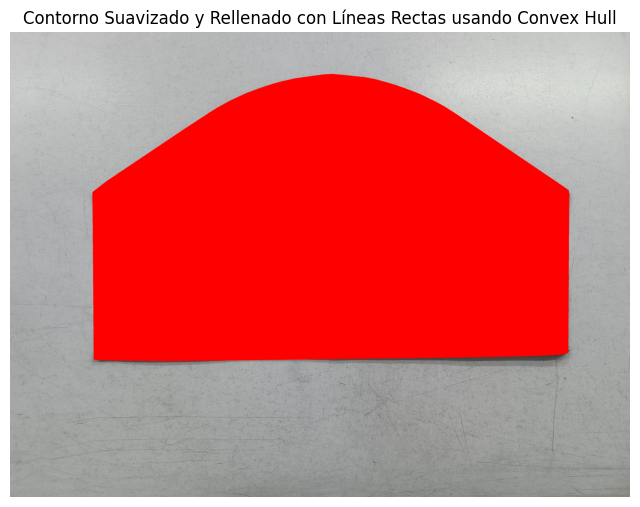

Ancho en píxeles: 3073.0738398888016
Largo en píxeles: 1851.6819633284247
Área de toda la figura en pixeles: 12000000
Relación píxeles/cm (ancho): 85.36
Relación píxeles/cm (largo): 80.51
Relación píxeles/cm²: 6872.41
Área en píxeles cuadrados: 4750460.53
Área en centímetros cuadrados: 691.24 cm²
Relación porcentual: 39.59%


In [6]:
# Cargar la imagen
imagen = cv2.imread('inputs/Manga corta.jpg')

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro gaussiano para suavizar la imagen
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar un umbral adaptativo para binarizar la imagen
th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV, 11, 2)

# Encontrar los contornos en la imagen binarizada
contornos, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Suponiendo que deseas trabajar con el contorno más grande
cnt = max(contornos, key=cv2.contourArea)

# Suavizar el contorno utilizando B-splines
contorno_suavizado = suavizar_contorno(cnt, s=0.01)

# Encontrar el convex hull (envolvente convexa) del contorno suavizado
hull = cv2.convexHull(contorno_suavizado.astype(np.float32))

# Crear un polígono a partir del convex hull
hull_pts = np.array([p[0] for p in hull])
poligono_cerrado = Polygon(hull_pts)

# Dibujar el contorno suavizado
imagen_rellena = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
cv2.drawContours(imagen_rellena, [hull_pts.astype(np.int32)], -1, (255, 0, 0), 2)

# Rellenar el área dentro del convex hull
cv2.fillPoly(imagen_rellena, [hull_pts.astype(np.int32)], (255, 0, 0))

# Obtener las dimensiones de la imagen
alto, ancho, _ = imagen.shape

# Calcular el número total de píxeles en la imagen
pixeles_totales = alto * ancho

# Calcular las dimensiones del contorno suavizado
x_min = np.min(contorno_suavizado[:, 0])
x_max = np.max(contorno_suavizado[:, 0])
y_min = np.min(contorno_suavizado[:, 1])
y_max = np.max(contorno_suavizado[:, 1])

# Calcular ancho y largo en píxeles
ancho_pixeles = x_max - x_min
largo_pixeles = y_max - y_min

# Definir las dimensiones reales en centímetros
ancho_real_cm = 36  # Ancho real en cm
largo_real_cm = 23 # Largo real en cm

# Calcular la relación de píxeles a centímetros
pixeles_por_cm_ancho = ancho_pixeles / ancho_real_cm
pixeles_por_cm_largo = largo_pixeles / largo_real_cm

# Calcular la relación de píxeles por cm²
pixeles_por_cm2 = pixeles_por_cm_ancho * pixeles_por_cm_largo

# Calcular el área en píxeles cuadrados del polígono
area_pixeles = poligono_cerrado.area

# Calcular el área en centímetros cuadrados
area_cm_cuadrados = area_pixeles / pixeles_por_cm2

#Calcular la relación porcentual
relacion_porcentual = (area_pixeles / pixeles_totales) * 100

# Mostrar la imagen con el área rellenada
plt.figure(figsize=(8, 8))
plt.imshow(imagen_rellena)
plt.axis('off')
plt.title('Contorno Suavizado y Rellenado con Líneas Rectas usando Convex Hull')
plt.show()

# Mostrar las relaciones calculadas
print(f"Ancho en píxeles: {ancho_pixeles}")
print(f"Largo en píxeles: {largo_pixeles}")
print(f"Área de toda la figura en pixeles: {pixeles_totales}")
print(f"Relación píxeles/cm (ancho): {pixeles_por_cm_ancho:.2f}")
print(f"Relación píxeles/cm (largo): {pixeles_por_cm_largo:.2f}")
print(f"Relación píxeles/cm²: {pixeles_por_cm2:.2f}")
print(f"Área en píxeles cuadrados: {area_pixeles:.2f}")
print(f"Área en centímetros cuadrados: {area_cm_cuadrados:.2f} cm²")
print(f"Relación porcentual: {relacion_porcentual:.2f}%")

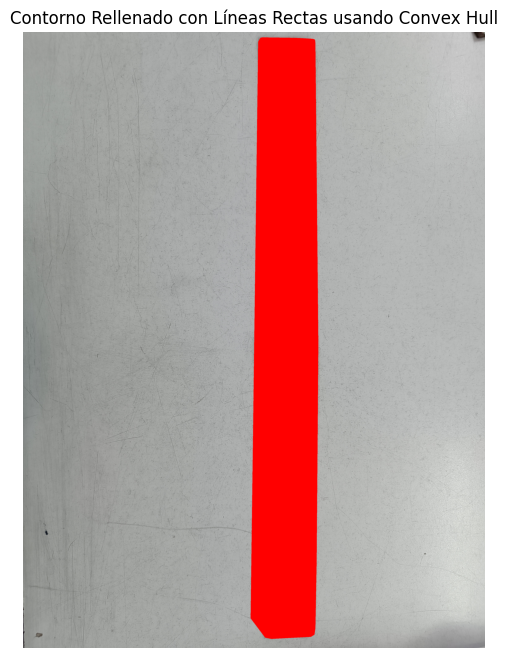

In [7]:
# Cargar la imagen
imagen = cv2.imread('inputs/Cuello.jpg')

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Aplicar un umbral para binarizar la imagen
_, th = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Encontrar los contornos en la imagen binarizada
contornos, hierarchy = cv2.findContours(th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Suponiendo que deseas trabajar con el contorno más grande
cnt = max(contornos, key=cv2.contourArea)

# Encontrar el convex hull (envolvente convexa) del contorno
hull = cv2.convexHull(cnt)

# Crear un polígono a partir del convex hull
hull_pts = np.array([p[0] for p in hull])
poligono_cerrado = Polygon(hull_pts)

# Convertir los puntos del polígono a listas y agregarlos a 'polys' directamente
polys.append([list(coord) for coord in poligono_cerrado.exterior.coords])

# Dibujar el convex hull (contorno cerrado con líneas rectas)
imagen_rellena = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
cv2.drawContours(imagen_rellena, [hull_pts.astype(np.int32)], -1, (255, 0, 0), 2)

# Rellenar el área dentro del convex hull
cv2.fillPoly(imagen_rellena, [hull_pts.astype(np.int32)], (255, 0, 0))

# Mostrar la imagen con el área rellenada
plt.figure(figsize=(8, 8))
plt.imshow(imagen_rellena)
plt.axis('off')
plt.title('Contorno Rellenado con Líneas Rectas usando Convex Hull')
plt.show()

In [8]:
polys

[[[3606.30908203125, 1048.474609375],
  [3600.978271484375, 2063.612548828125],
  [3592.555419921875, 2072.077392578125],
  [3565.022216796875, 2079.0634765625],
  [3478.986328125, 2085.424072265625],
  [3364.596923828125, 2089.897216796875],
  [3068.226318359375, 2096.59228515625],
  [1042.7464599609375, 2122.681884765625],
  [710.4872436523438, 2118.423095703125],
  [563.9136962890625, 2115.3623046875],
  [542.3364868164062, 2112.274658203125],
  [541.5873413085938, 2091.215576171875],
  [533.2351684570312, 1033.783203125],
  [622.0679321289062, 964.9617309570312],
  [1118.2828369140625, 631.0604248046875],
  [1291.9940185546875, 518.0599975585938],
  [1339.660400390625, 488.0190124511719],
  [1413.43505859375, 447.6376647949219],
  [1489.6639404296875, 411.7674865722656],
  [1514.611083984375, 400.1089782714844],
  [1540.266357421875, 389.25653076171875],
  [1618.193359375, 360.9742126464844],
  [1644.9207763671875, 352.198974609375],
  [1698.52197265625, 334.9236145019531],
  [1750

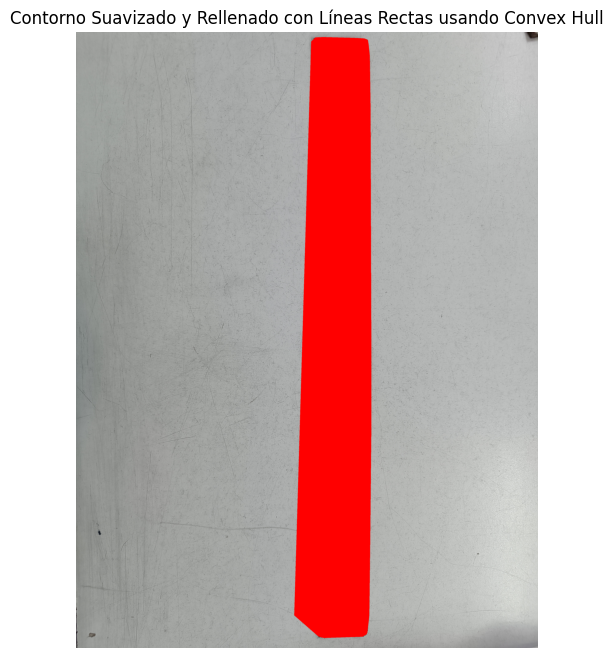

Ancho en píxeles: 498.2548091803458
Largo en píxeles: 3898.934409001091
Área de toda la figura en pixeles: 12000000
Relación píxeles/cm (ancho): 110.72
Relación píxeles/cm (largo): 79.57
Relación píxeles/cm²: 8810.26
Área en píxeles cuadrados: 1698743.68
Área en centímetros cuadrados: 192.81 cm²
Relación porcentual: 14.16%


In [9]:
# Cargar la imagen
imagen = cv2.imread('inputs/Cuello.jpg')

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro gaussiano para suavizar la imagen
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar un umbral adaptativo para binarizar la imagen
th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV, 11, 2)

# Encontrar los contornos en la imagen binarizada
contornos, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Suponiendo que deseas trabajar con el contorno más grande
cnt = max(contornos, key=cv2.contourArea)

# Suavizar el contorno utilizando B-splines
contorno_suavizado = suavizar_contorno(cnt, s=0.01)

# Encontrar el convex hull (envolvente convexa) del contorno suavizado
hull = cv2.convexHull(contorno_suavizado.astype(np.float32))

# Crear un polígono a partir del convex hull
hull_pts = np.array([p[0] for p in hull])
poligono_cerrado = Polygon(hull_pts)

# Dibujar el contorno suavizado
imagen_rellena = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
cv2.drawContours(imagen_rellena, [hull_pts.astype(np.int32)], -1, (255, 0, 0), 2)

# Rellenar el área dentro del convex hull
cv2.fillPoly(imagen_rellena, [hull_pts.astype(np.int32)], (255, 0, 0))

# Obtener las dimensiones de la imagen
alto, ancho, _ = imagen.shape

# Calcular el número total de píxeles en la imagen
pixeles_totales = alto * ancho

# Calcular las dimensiones del contorno suavizado
x_min = np.min(contorno_suavizado[:, 0])
x_max = np.max(contorno_suavizado[:, 0])
y_min = np.min(contorno_suavizado[:, 1])
y_max = np.max(contorno_suavizado[:, 1])

# Calcular ancho y largo en píxeles
ancho_pixeles = x_max - x_min
largo_pixeles = y_max - y_min

# Definir las dimensiones reales en centímetros
ancho_real_cm = 4.5  # Ancho real en cm
largo_real_cm = 49 # Largo real en cm

# Calcular la relación de píxeles a centímetros
pixeles_por_cm_ancho = ancho_pixeles / ancho_real_cm
pixeles_por_cm_largo = largo_pixeles / largo_real_cm

# Calcular la relación de píxeles por cm²
pixeles_por_cm2 = pixeles_por_cm_ancho * pixeles_por_cm_largo

# Calcular el área en píxeles cuadrados del polígono
area_pixeles = poligono_cerrado.area

# Calcular el área en centímetros cuadrados
area_cm_cuadrados = area_pixeles / pixeles_por_cm2

#Calcular la relación porcentual
relacion_porcentual = (area_pixeles / pixeles_totales) * 100

# Mostrar la imagen con el área rellenada
plt.figure(figsize=(8, 8))
plt.imshow(imagen_rellena)
plt.axis('off')
plt.title('Contorno Suavizado y Rellenado con Líneas Rectas usando Convex Hull')
plt.show()

# Mostrar las relaciones calculadas
print(f"Ancho en píxeles: {ancho_pixeles}")
print(f"Largo en píxeles: {largo_pixeles}")
print(f"Área de toda la figura en pixeles: {pixeles_totales}")
print(f"Relación píxeles/cm (ancho): {pixeles_por_cm_ancho:.2f}")
print(f"Relación píxeles/cm (largo): {pixeles_por_cm_largo:.2f}")
print(f"Relación píxeles/cm²: {pixeles_por_cm2:.2f}")
print(f"Área en píxeles cuadrados: {area_pixeles:.2f}")
print(f"Área en centímetros cuadrados: {area_cm_cuadrados:.2f} cm²")
print(f"Relación porcentual: {relacion_porcentual:.2f}%")

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:298: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


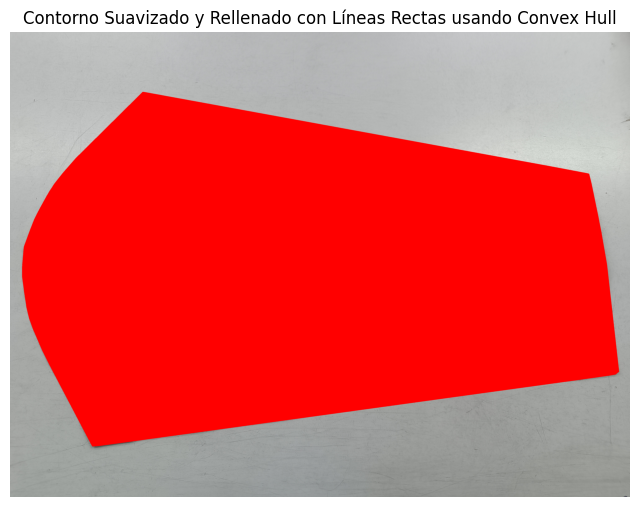

In [10]:
# Cargar la imagen
imagen = cv2.imread('inputs/Manga larga.jpg')

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro gaussiano para suavizar la imagen
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar un umbral adaptativo para binarizar la imagen
th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV, 11, 2)

# Encontrar los contornos en la imagen binarizada
contornos, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Suponiendo que deseas trabajar con el contorno más grande
cnt = max(contornos, key=cv2.contourArea)

# Suavizar el contorno utilizando B-splines
contorno_suavizado = suavizar_contorno(cnt, s=0.01)

# Encontrar el convex hull (envolvente convexa) del contorno suavizado
hull = cv2.convexHull(contorno_suavizado.astype(np.float32))

# Crear un polígono a partir del convex hull
hull_pts = np.array([p[0] for p in hull])
poligono_cerrado = Polygon(hull_pts)
polys.append([list(coord) for coord in poligono_cerrado.exterior.coords])

# Dibujar el contorno suavizado
imagen_rellena = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
cv2.drawContours(imagen_rellena, [hull_pts.astype(np.int32)], -1, (255, 0, 0), 2)

# Rellenar el área dentro del convex hull
cv2.fillPoly(imagen_rellena, [hull_pts.astype(np.int32)], (255, 0, 0))

# Mostrar la imagen con el área rellenada
plt.figure(figsize=(8, 8))
plt.imshow(imagen_rellena)
plt.axis('off')
plt.title('Contorno Suavizado y Rellenado con Líneas Rectas usando Convex Hull')
plt.show()

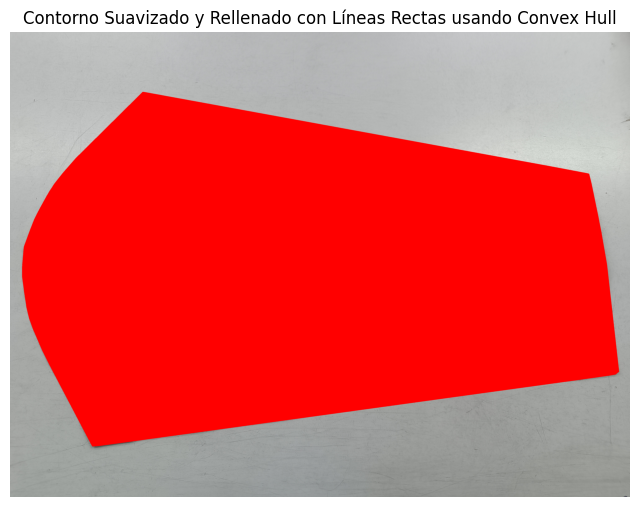

Ancho en píxeles: 3848.6281973446585
Largo en píxeles: 2285.7694888481665
Área de toda la figura en pixeles: 12000000
Relación píxeles/cm (ancho): 63.09
Relación píxeles/cm (largo): 60.15
Relación píxeles/cm²: 3795.12
Área en píxeles cuadrados: 6524063.94
Área en centímetros cuadrados: 1719.07 cm²
Relación porcentual: 54.37%


In [11]:
# Cargar la imagen
imagen = cv2.imread('inputs/Manga larga.jpg')

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro gaussiano para suavizar la imagen
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar un umbral adaptativo para binarizar la imagen
th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV, 11, 2)

# Encontrar los contornos en la imagen binarizada
contornos, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Suponiendo que deseas trabajar con el contorno más grande
cnt = max(contornos, key=cv2.contourArea)

# Suavizar el contorno utilizando B-splines
contorno_suavizado = suavizar_contorno(cnt, s=0.01)

# Encontrar el convex hull (envolvente convexa) del contorno suavizado
hull = cv2.convexHull(contorno_suavizado.astype(np.float32))

# Crear un polígono a partir del convex hull
hull_pts = np.array([p[0] for p in hull])
poligono_cerrado = Polygon(hull_pts)

# Dibujar el contorno suavizado
imagen_rellena = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
cv2.drawContours(imagen_rellena, [hull_pts.astype(np.int32)], -1, (255, 0, 0), 2)

# Rellenar el área dentro del convex hull
cv2.fillPoly(imagen_rellena, [hull_pts.astype(np.int32)], (255, 0, 0))

# Obtener las dimensiones de la imagen
alto, ancho, _ = imagen.shape

# Calcular el número total de píxeles en la imagen
pixeles_totales = alto * ancho

# Calcular las dimensiones del contorno suavizado
x_min = np.min(contorno_suavizado[:, 0])
x_max = np.max(contorno_suavizado[:, 0])
y_min = np.min(contorno_suavizado[:, 1])
y_max = np.max(contorno_suavizado[:, 1])

# Calcular ancho y largo en píxeles
ancho_pixeles = x_max - x_min
largo_pixeles = y_max - y_min

# Definir las dimensiones reales en centímetros
ancho_real_cm = 61  # Ancho real en cm
largo_real_cm = 38 # Largo real en cm

# Calcular la relación de píxeles a centímetros
pixeles_por_cm_ancho = ancho_pixeles / ancho_real_cm
pixeles_por_cm_largo = largo_pixeles / largo_real_cm

# Calcular la relación de píxeles por cm²
pixeles_por_cm2 = pixeles_por_cm_ancho * pixeles_por_cm_largo

# Calcular el área en píxeles cuadrados del polígono
area_pixeles = poligono_cerrado.area

# Calcular el área en centímetros cuadrados
area_cm_cuadrados = area_pixeles / pixeles_por_cm2

relacion_porcentual = (area_pixeles / pixeles_totales) * 100

# Mostrar la imagen con el área rellenada
plt.figure(figsize=(8, 8))
plt.imshow(imagen_rellena)
plt.axis('off')
plt.title('Contorno Suavizado y Rellenado con Líneas Rectas usando Convex Hull')
plt.show()

# Mostrar las relaciones calculadas
print(f"Ancho en píxeles: {ancho_pixeles}")
print(f"Largo en píxeles: {largo_pixeles}")
print(f"Área de toda la figura en pixeles: {pixeles_totales}")
print(f"Relación píxeles/cm (ancho): {pixeles_por_cm_ancho:.2f}")
print(f"Relación píxeles/cm (largo): {pixeles_por_cm_largo:.2f}")
print(f"Relación píxeles/cm²: {pixeles_por_cm2:.2f}")
print(f"Área en píxeles cuadrados: {area_pixeles:.2f}")
print(f"Área en centímetros cuadrados: {area_cm_cuadrados:.2f} cm²")
print(f"Relación porcentual: {relacion_porcentual:.2f}%")

In [12]:
polys

[[[3606.30908203125, 1048.474609375],
  [3600.978271484375, 2063.612548828125],
  [3592.555419921875, 2072.077392578125],
  [3565.022216796875, 2079.0634765625],
  [3478.986328125, 2085.424072265625],
  [3364.596923828125, 2089.897216796875],
  [3068.226318359375, 2096.59228515625],
  [1042.7464599609375, 2122.681884765625],
  [710.4872436523438, 2118.423095703125],
  [563.9136962890625, 2115.3623046875],
  [542.3364868164062, 2112.274658203125],
  [541.5873413085938, 2091.215576171875],
  [533.2351684570312, 1033.783203125],
  [622.0679321289062, 964.9617309570312],
  [1118.2828369140625, 631.0604248046875],
  [1291.9940185546875, 518.0599975585938],
  [1339.660400390625, 488.0190124511719],
  [1413.43505859375, 447.6376647949219],
  [1489.6639404296875, 411.7674865722656],
  [1514.611083984375, 400.1089782714844],
  [1540.266357421875, 389.25653076171875],
  [1618.193359375, 360.9742126464844],
  [1644.9207763671875, 352.198974609375],
  [1698.52197265625, 334.9236145019531],
  [1750

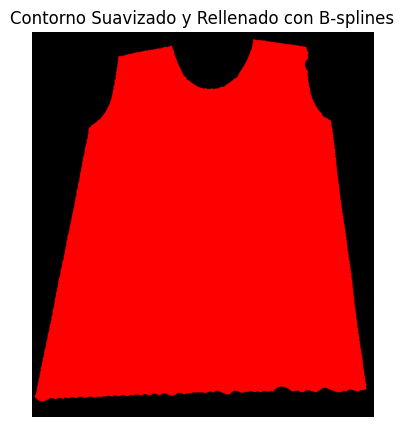

Ancho en píxeles: 1098.121226451473
Largo en píxeles: 1203.1286368268368
Área de toda la figura en pixeles: 1451520
Relación píxeles/cm (ancho): 21.87
Relación píxeles/cm (alto): 16.26
Área en píxeles cuadrados: 989415.76
Relación píxeles/cm²: 355.65
Área en centímetros cuadrados: 2781.97 cm²
Relación porcentual: 68.16%


In [13]:
def calcular_relacion_pixeles_cm(imagen_ruta, ancho_real_cm, largo_real_cm):
    # Cargar la imagen
    imagen = cv2.imread(imagen_ruta)

    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Aplicar un filtro gaussiano para suavizar la imagen
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Aplicar un umbral adaptativo para binarizar la imagen
    th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, 11, 2)

    # Encontrar los contornos en la imagen binarizada
    contornos, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Suponiendo que deseas trabajar con el contorno más grande
    cnt = max(contornos, key=cv2.contourArea)

    # Suavizar el contorno utilizando B-splines
    contorno_suavizado = suavizar_contorno(cnt, s=0.01)

    # Crear una imagen en blanco para dibujar el contorno suavizado
    imagen_rellena = np.zeros_like(imagen)
    imagen_rellena = cv2.cvtColor(imagen_rellena, cv2.COLOR_BGR2RGB)

    # Dibujar y rellenar el contorno suavizado directamente
    contorno_suavizado_int = contorno_suavizado.astype(np.int32)

    # Asegurarse de que el contorno es un polígono cerrado
    if not np.array_equal(contorno_suavizado_int[0], contorno_suavizado_int[-1]):
        contorno_suavizado_int = np.vstack([contorno_suavizado_int, contorno_suavizado_int[0]])

    # Rellenar el área dentro del contorno suavizado
    cv2.fillPoly(imagen_rellena, [contorno_suavizado_int], (255, 0, 0))

    # Identificar los puntos más a la izquierda, derecha, superior e inferior del contorno suavizado
    x_min = np.min(contorno_suavizado[:, 0])
    x_max = np.max(contorno_suavizado[:, 0])
    y_min = np.min(contorno_suavizado[:, 1])
    y_max = np.max(contorno_suavizado[:, 1])

    # Calcular el ancho y alto en píxeles usando los puntos extremos
    ancho_pixeles = x_max - x_min
    largo_pixeles = y_max - y_min

    # Calcular la relación de píxeles a centímetros
    pixeles_por_cm_ancho = ancho_pixeles / ancho_real_cm
    pixeles_por_cm_alto = largo_pixeles / largo_real_cm

    # Calcular la relación de píxeles/cm²
    pixeles_por_cm2_total = pixeles_por_cm_ancho * pixeles_por_cm_alto

    # Calcular el área en píxeles cuadrados
    poligono = Polygon(contorno_suavizado)
    area_pixeles = poligono.area

    # Obtener las dimensiones de la imagen
    alto, ancho, _ = imagen.shape

    # Calcular el número total de píxeles en la imagen
    pixeles_totales = alto * ancho

    # Convertir el área en píxeles cuadrados a centímetros cuadrados
    area_cm_cuadrados = area_pixeles / pixeles_por_cm2_total

    relacion_porcentual = (area_pixeles / pixeles_totales) * 100

    # Mostrar la imagen con el área rellenada
    plt.figure(figsize=(5, 5))
    plt.imshow(imagen_rellena)
    plt.axis('off')
    plt.title('Contorno Suavizado y Rellenado con B-splines')
    plt.show()

    # Imprimir información del polígono y relación de píxeles a cm²
    print(f"Ancho en píxeles: {ancho_pixeles}")
    print(f"Largo en píxeles: {largo_pixeles}")
    print(f"Área de toda la figura en pixeles: {pixeles_totales}")
    print(f"Relación píxeles/cm (ancho): {pixeles_por_cm_ancho:.2f}")
    print(f"Relación píxeles/cm (alto): {pixeles_por_cm_alto:.2f}")
    print(f"Área en píxeles cuadrados: {area_pixeles:.2f}")
    print(f"Relación píxeles/cm²: {pixeles_por_cm2_total:.2f}")
    print(f"Área en centímetros cuadrados: {area_cm_cuadrados:.2f} cm²")
    print(f"Relación porcentual: {relacion_porcentual:.2f}%")

# Ejemplo de uso
imagen_ruta = 'inputs/Delantero.jpeg'
ancho_real_cm = 50.2  # Reemplaza con el ancho real en cm
largo_real_cm = 74  # Reemplaza con el largo real en cm

calcular_relacion_pixeles_cm(imagen_ruta, ancho_real_cm, largo_real_cm)

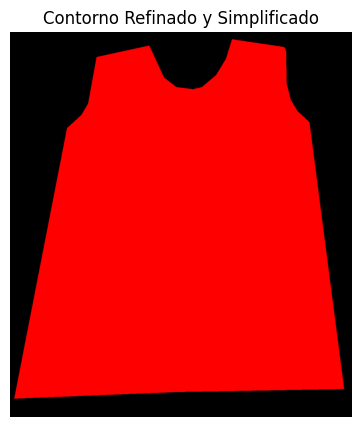

Coordenadas del contorno simplificado: [[909, 50], [736, 24], [716, 89], [683, 143], [636, 183], [606, 190], [551, 183], [510, 151], [461, 45], [287, 83], [259, 237], [237, 275], [189, 319], [14, 1218], [553, 1196], [1107, 1186], [992, 299], [953, 263], [930, 225], [916, 168], [915, 64], [909, 50]]


In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

def detect_curvature(contour, window_size=5):
    """
    Detecta la curvatura del contorno.
    :param contour: Contorno a analizar.
    :param window_size: Tamaño de la ventana para calcular la curvatura.
    :return: Indices de puntos con alta curvatura.
    """
    curvature = []
    for i in range(len(contour)):
        p_prev = contour[i - window_size]
        p_curr = contour[i]
        p_next = contour[(i + window_size) % len(contour)]

        v1 = p_curr - p_prev
        v2 = p_next - p_curr

        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        curvature.append(1 - cos_theta)

    curvature = np.array(curvature)
    high_curvature_indices = np.where(curvature > np.percentile(curvature, 95))[0]

    return high_curvature_indices

def refine_contour(contour, high_curvature_indices):
    """
    Refina el contorno manteniendo los puntos de alta curvatura.
    """
    refined_contour = []
    for i in range(len(contour)):
        if i in high_curvature_indices:
            refined_contour.append(contour[i])
        else:
            if len(refined_contour) == 0 or np.linalg.norm(np.array(refined_contour[-1]) - np.array(contour[i])) > 1:
                refined_contour.append(contour[i])
    return np.array(refined_contour)

def simplify_contour(contour, epsilon=1):
    """
    Simplifica el contorno utilizando el algoritmo Ramer-Douglas-Peucker.
    :param contour: Contorno a simplificar.
    :param epsilon: Tolerancia de simplificación.
    :return: Contorno simplificado.
    """
    simplified_contour = cv2.approxPolyDP(contour, epsilon, closed=True)
    return simplified_contour[:, 0, :]  # Remover una dimensión innecesaria

# Cargar la imagen
imagen = cv2.imread('inputs/Delantero.jpeg')

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro gaussiano para suavizar la imagen
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar un umbral adaptativo para binarizar la imagen
th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                           cv2.THRESH_BINARY_INV, 11, 2)

# Encontrar los contornos en la imagen binarizada
contornos, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Suponiendo que deseas trabajar con el contorno más grande
cnt = max(contornos, key=cv2.contourArea)[:, 0, :]  # Quitar una dimensión innecesaria

# Detectar puntos de alta curvatura
curvature_indices = detect_curvature(cnt, window_size=5)

# Refinar el contorno manteniendo las curvas importantes
contorno_refinado = refine_contour(cnt, curvature_indices)

# Simplificar el contorno refinado
contorno_simplificado = simplify_contour(contorno_refinado, epsilon=5.0)

# Asegurarse de que el contorno es un polígono cerrado
if not np.array_equal(contorno_simplificado[0], contorno_simplificado[-1]):
    contorno_simplificado = np.vstack([contorno_simplificado, contorno_simplificado[0]])

# Crear una imagen en blanco para dibujar el contorno refinado y simplificado
imagen_rellena = np.zeros_like(imagen)
imagen_rellena = cv2.cvtColor(imagen_rellena, cv2.COLOR_BGR2RGB)

# Rellenar el área dentro del contorno refinado y simplificado
cv2.fillPoly(imagen_rellena, [np.array(contorno_simplificado, dtype=np.int32)], (255, 0, 0))

# Mostrar la imagen con el área rellenada
plt.figure(figsize=(5, 5))
plt.imshow(imagen_rellena)
plt.axis('off')
plt.title('Contorno Refinado y Simplificado')
plt.show()

# Imprimir las coordenadas del contorno refinado y simplificado
print("Coordenadas del contorno simplificado:", contorno_simplificado.tolist())
# polys.append(contorno_simplificado.tolist())

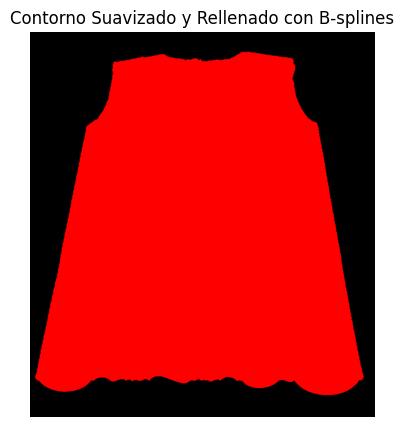

Ancho en píxeles: 1090.9118450202004
Largo en píxeles: 1141.056078812971
Área de toda la figura en pixeles: 1466880
Relación píxeles/cm (ancho): 21.73
Relación píxeles/cm (alto): 15.42
Área en píxeles cuadrados: 941937.75
Relación píxeles/cm²: 335.09
Área en centímetros cuadrados: 2811.00 cm²
Relación porcentual: 64.21%


In [15]:
# Ejemplo de uso
imagen_ruta = 'inputs/Espalda def.jpeg'
ancho_real_cm = 50.2  # Reemplaza con el ancho real en cm
largo_real_cm = 74  # Reemplaza con el largo real en cm

calcular_relacion_pixeles_cm(imagen_ruta, ancho_real_cm, largo_real_cm)

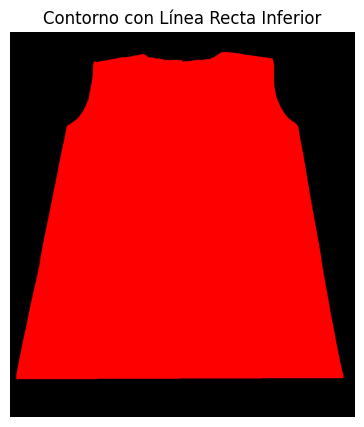

In [16]:
# Cargar la imagen
imagen = cv2.imread('inputs/Espalda def.jpeg')

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro gaussiano para suavizar la imagen
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar un umbral adaptativo para binarizar la imagen
th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV, 11, 2)

# Encontrar los contornos en la imagen binarizada
contornos, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Suponiendo que deseas trabajar con el contorno más grande
cnt = max(contornos, key=cv2.contourArea)

# Convertir el contorno a formato adecuado
cnt = cnt[:, 0, :]  # quitar una dimensión innecesaria

# Identificar los puntos más a la izquierda y derecha en la parte inferior del contorno
y_max = np.max(cnt[:, 1])
indices_inferiores = np.where(cnt[:, 1] >= y_max - 10)[0]

# Obtener los puntos inicial y final de la parte inferior
punto_inicio = cnt[indices_inferiores[0]]
punto_fin = cnt[indices_inferiores[-1]]

# Crear la línea recta inferior
linea_inferior = np.linspace(punto_inicio, punto_fin, 100).astype(np.int32)

# Dividir el contorno en la parte superior y el resto
contorno_superior = cnt[:indices_inferiores[0] + 1]
contorno_inferior = linea_inferior

# Unir la parte superior con la línea inferior y el resto del contorno
nuevo_contorno = np.vstack([contorno_superior, contorno_inferior, cnt[indices_inferiores[-1] + 1:]])

# Crear una imagen en blanco para dibujar el nuevo contorno
imagen_rellena = np.zeros_like(imagen)
imagen_rellena = cv2.cvtColor(imagen_rellena, cv2.COLOR_BGR2RGB)

# Dibujar y rellenar el nuevo contorno directamente
nuevo_contorno_int = nuevo_contorno.astype(np.int32)

# Asegurarse de que el contorno es un polígono cerrado
if not np.array_equal(nuevo_contorno_int[0], nuevo_contorno_int[-1]):
    nuevo_contorno_int = np.vstack([nuevo_contorno_int, nuevo_contorno_int[0]])

# Rellenar el área dentro del nuevo contorno
cv2.fillPoly(imagen_rellena, [nuevo_contorno_int], (255, 0, 0))

# Mostrar la imagen con el área rellenada
plt.figure(figsize=(5, 5))
plt.imshow(imagen_rellena)
plt.axis('off')
plt.title('Contorno con Línea Recta Inferior')
plt.show()

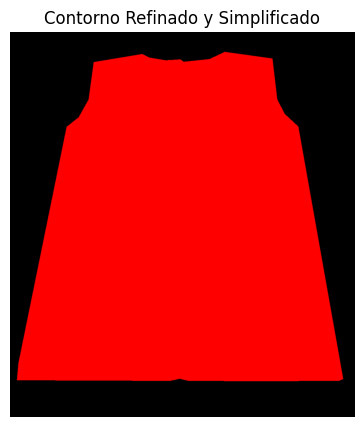

Coordenadas del contorno simplificado: [[871, 88], [713, 66], [662, 90], [576, 99], [566, 91], [516, 94], [462, 85], [439, 73], [278, 100], [261, 224], [228, 283], [188, 315], [28, 1100], [23, 1157], [531, 1159], [563, 1152], [593, 1159], [825, 1160], [1092, 1159], [1106, 1153], [957, 314], [912, 272], [887, 224], [871, 88]]


In [17]:
# Cargar la imagen
imagen = cv2.imread('inputs/Espalda def.jpeg')

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro gaussiano para suavizar la imagen
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar un umbral adaptativo para binarizar la imagen
th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                           cv2.THRESH_BINARY_INV, 11, 2)

# Encontrar los contornos en la imagen binarizada
contornos, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Suponiendo que deseas trabajar con el contorno más grande
cnt = max(contornos, key=cv2.contourArea)[:, 0, :]  # Quitar una dimensión innecesaria

# Detectar puntos de alta curvatura
curvature_indices = detect_curvature(cnt, window_size=5)

# Refinar el contorno manteniendo las curvas importantes
contorno_refinado = refine_contour(cnt, curvature_indices)

# Simplificar el contorno refinado
contorno_simplificado = simplify_contour(contorno_refinado, epsilon=5.0)

# Asegurarse de que el contorno es un polígono cerrado
if not np.array_equal(contorno_simplificado[0], contorno_simplificado[-1]):
    contorno_simplificado = np.vstack([contorno_simplificado, contorno_simplificado[0]])

# Crear una imagen en blanco para dibujar el contorno refinado y simplificado
imagen_rellena = np.zeros_like(imagen)
imagen_rellena = cv2.cvtColor(imagen_rellena, cv2.COLOR_BGR2RGB)

# Rellenar el área dentro del contorno refinado y simplificado
cv2.fillPoly(imagen_rellena, [np.array(contorno_simplificado, dtype=np.int32)], (255, 0, 0))

# Mostrar la imagen con el área rellenada
plt.figure(figsize=(5, 5))
plt.imshow(imagen_rellena)
plt.axis('off')
plt.title('Contorno Refinado y Simplificado')
plt.show()

# Imprimir las coordenadas del contorno refinado y simplificado
print("Coordenadas del contorno simplificado:", contorno_simplificado.tolist())
polys.append(contorno_simplificado.tolist())

In [18]:
polys

[[[3606.30908203125, 1048.474609375],
  [3600.978271484375, 2063.612548828125],
  [3592.555419921875, 2072.077392578125],
  [3565.022216796875, 2079.0634765625],
  [3478.986328125, 2085.424072265625],
  [3364.596923828125, 2089.897216796875],
  [3068.226318359375, 2096.59228515625],
  [1042.7464599609375, 2122.681884765625],
  [710.4872436523438, 2118.423095703125],
  [563.9136962890625, 2115.3623046875],
  [542.3364868164062, 2112.274658203125],
  [541.5873413085938, 2091.215576171875],
  [533.2351684570312, 1033.783203125],
  [622.0679321289062, 964.9617309570312],
  [1118.2828369140625, 631.0604248046875],
  [1291.9940185546875, 518.0599975585938],
  [1339.660400390625, 488.0190124511719],
  [1413.43505859375, 447.6376647949219],
  [1489.6639404296875, 411.7674865722656],
  [1514.611083984375, 400.1089782714844],
  [1540.266357421875, 389.25653076171875],
  [1618.193359375, 360.9742126464844],
  [1644.9207763671875, 352.198974609375],
  [1698.52197265625, 334.9236145019531],
  [1750

## Heurística de Bottom Left Fill

In [19]:
for i, poly in enumerate(polys):
    print(f"Polígono {i}: {poly}")

Polígono 0: [[3606.30908203125, 1048.474609375], [3600.978271484375, 2063.612548828125], [3592.555419921875, 2072.077392578125], [3565.022216796875, 2079.0634765625], [3478.986328125, 2085.424072265625], [3364.596923828125, 2089.897216796875], [3068.226318359375, 2096.59228515625], [1042.7464599609375, 2122.681884765625], [710.4872436523438, 2118.423095703125], [563.9136962890625, 2115.3623046875], [542.3364868164062, 2112.274658203125], [541.5873413085938, 2091.215576171875], [533.2351684570312, 1033.783203125], [622.0679321289062, 964.9617309570312], [1118.2828369140625, 631.0604248046875], [1291.9940185546875, 518.0599975585938], [1339.660400390625, 488.0190124511719], [1413.43505859375, 447.6376647949219], [1489.6639404296875, 411.7674865722656], [1514.611083984375, 400.1089782714844], [1540.266357421875, 389.25653076171875], [1618.193359375, 360.9742126464844], [1644.9207763671875, 352.198974609375], [1698.52197265625, 334.9236145019531], [1750.106689453125, 320.9364013671875], [1

In [20]:
bias = 0.000001  # sesgo

class GeoFunc(object):
    '''
    1. checkBottom, checkTop, checkLeft y checkRight no consideran múltiples puntos por el momento.
    2. Tanto checkBottom como checkLeft consideran la esquina inferior izquierda
    '''

    @staticmethod
    def is_valid_polygon(poly):
        """
        Verifica si un polígono es válido (tiene al menos 3 puntos y un área positiva).
        """
        if len(poly) < 3:
            return False
        polygon = Polygon(poly)
        return polygon.is_valid and polygon.area > 0
    def almostContain(line, point, bias=0.01):
        line_geom = LineString(line)
        point_geom = Point(point)
        return line_geom.distance(point_geom) < bias

    def computeInterArea(orginal_inter):
        inter = mapping(orginal_inter)
        # Un polígono
        if inter["type"] == "Polygon":
            if len(inter["coordinates"]) > 0:
                poly = inter["coordinates"][0]
                return Polygon(poly).area
            else:
                return 0
        # Multipolígono
        if inter["type"] == "MultiPolygon":
            area = 0
            for _arr in inter["coordinates"]:
                poly = _arr[0]
                area += Polygon(poly).area
            return area
        # Colección de geometrías
        if inter["type"] == "GeometryCollection":
            area = 0
            for _arr in inter["geometries"]:
                if _arr["type"] == "Polygon":
                    poly = _arr["coordinates"][0]
                    area += Polygon(poly).area
            return area
        return 0

    def checkBottom(poly):
        polyP = Polygon(poly)
        min_y = polyP.bounds[1]
        for index, point in enumerate(poly):
            if point[1] == min_y:
                return index

    def checkTop(poly):
        polyP = Polygon(poly)
        max_y = polyP.bounds[3]
        for index, point in enumerate(poly):
            if point[1] == max_y:
                return index

    def checkLeft(poly):
        polyP = Polygon(poly)
        min_x = polyP.bounds[0]
        for index, point in enumerate(poly):
            if point[0] == min_x:
                return index

    def checkRight(poly):
        polyP = Polygon(poly)
        max_x = polyP.bounds[2]
        for index, point in enumerate(poly):
            if point[0] == max_x:
                return index

    def checkBound(poly):
        return GeoFunc.checkLeft(poly), GeoFunc.checkBottom(poly), GeoFunc.checkRight(poly), GeoFunc.checkTop(poly)

    def checkBoundPt(poly):
        left, bottom, right, top = poly[0], poly[0], poly[0], poly[0]
        for i, pt in enumerate(poly):
            if pt[0] < left[0]:
                left = pt
            if pt[0] > right[0]:
                right = pt
            if pt[1] > top[1]:
                top = pt
            if pt[1] < bottom[1]:
                bottom = pt
        return left, bottom, right, top

    def checkBoundValue(poly):
        left, bottom, right, top = poly[0][0], poly[0][1], poly[0][0], poly[0][1]
        for i, pt in enumerate(poly):
            if pt[0] < left:
                left = pt[0]
            if pt[0] > right:
                right = pt[0]
            if pt[1] > top:
                top = pt[1]
            if pt[1] < bottom:
                bottom = pt[1]
        return left, bottom, right, top

    def slidePoly(poly, x, y):
        for point in poly:
            point[0] = point[0]+x
            point[1] = point[1]+y

    def slideToPoint(poly, pt1, pt2):
        GeoFunc.slidePoly(poly, pt2[0]-pt1[0], pt2[1]-pt1[1])

    def getSlide(poly, x, y):
        new_vertex = []
        for point in poly:
            new_point = [point[0] + x, point[1] + y]
            new_vertex.append(new_point)
        return new_vertex

    @staticmethod
    def boundsContain(bounds, pt):
        if pt[0] >= bounds[0] and pt[0] <= bounds[2] and pt[1] >= bounds[1] and pt[1] <= bounds[3]:
            return True
        return False

    @staticmethod
    def polyToArr(polygon):
        res = mapping(polygon)
        _arr = []

        if res["type"] == "MultiPolygon":
            for part in res["coordinates"]:
                if part[0][0] != part[0][-1]:
                    for point in part[0]:
                        _arr.append([point[0], point[1]])
                else:
                    for point in part[0][0:-1]:
                        _arr.append([point[0], point[1]])
        else:
            if len(res["coordinates"]) > 0 and len(res["coordinates"][0]) > 0:
                if res["coordinates"][0][0] == res["coordinates"][0][-1]:
                    for point in res["coordinates"][0][0:-1]:
                        _arr.append([point[0], point[1]])
                else:
                    for point in res["coordinates"][0]:
                        _arr.append([point[0], point[1]])

        return _arr

    def normData(poly, num):
        for ver in poly:
            ver[0] = ver[0] * num
            ver[1] = ver[1] * num

    def crossProduct(vec1, vec2):
        res = vec1[0] * vec2[1] - vec1[1] * vec2[0]
    # Producto Cruz
        if abs(res) < bias:
            return 0
    # En algunos casos, el producto cruz es muy grande pero sigue siendo básicamente paralelo.
        if abs(vec1[0]) > bias and abs(vec2[0]) > bias:
            if abs(vec1[1] / vec1[0] - vec2[1] / vec2[0]) < bias:
                return 0
        return res

    def almostEqual(point1, point2, bias=0.00001):
        """
        Check if two points are almost equal within a given bias.
        Handles cases where inputs might be lists, tuples, or single numbers.
        """
        if isinstance(point1, (list, tuple)) and isinstance(point2, (list, tuple)):
            if len(point1) == 2 and len(point2) == 2:
                # Ensure both elements in the points are numeric
                if all(isinstance(x, (int, float)) for x in point1 + point2):
                    if abs(point1[0] - point2[0]) < bias and abs(point1[1] - point2[1]) < bias:
                        return True
        elif isinstance(point1, (int, float)) and isinstance(point2, (int, float)):
            if abs(point1 - point2) < bias:
                return True

    def intersection(line1, line2):
        Line1 = LineString(line1)
        Line2 = LineString(line2)
        inter = Line1.intersection(Line2)
        if not inter.is_empty:
            if inter.geom_type == "Point":
                return list(inter.coords[0])
            elif inter.geom_type == "MultiPoint":
                return [list(p.coords[0]) for p in inter.geoms]
            elif inter.geom_type == "LineString":
                return [list(p) for p in inter.coords]
        return []

    def reverseLine(line):
        pt0 = line[0]
        pt1 = line[1]
        return [[pt1[0], pt1[1]], [pt0[0], pt0[1]]]

    def copyPoly(poly):
        new_poly = []
        for pt in poly:
            new_poly.append([pt[0], pt[1]])
        return new_poly

    def lineToVec(edge):
        return [edge[1][0] - edge[0][0], edge[1][1] - edge[0][1]]

    def newLineInter(line1, line2):
        vec1 = GeoFunc.lineToVec(line1)
        vec2 = GeoFunc.lineToVec(line2)
        vec12_product = GeoFunc.crossProduct(vec1, vec2)
        Line1 = LineString(line1)
        Line2 = LineString(line2)
        inter = {
            "length": 0,
            "geom_type": None
        }
        # Sólo las líneas paralelas pueden superponerse
        if vec12_product == 0:
            # Copiar para evitar afectar el valor original.
            new_line1 = GeoFunc.copyPoly(line1)
            new_line2 = GeoFunc.copyPoly(line2)
            if vec1[0]*vec2[0] < 0 or vec1[1]*vec2[1] < 0:
                new_line2 = GeoFunc.reverseLine(new_line2)
            # Si hay vértices iguales, seleccione uno de ellos.
            if GeoFunc.almostEqual(new_line1[0], new_line2[0]) or GeoFunc.almostEqual(new_line1[1], new_line2[1]):
                inter["length"] = min(Line1.length, Line2.length)
                inter["geom_type"] = 'LineString'
                return inter
            # Excluir sólo situaciones de intersección de vértices
            if GeoFunc.almostEqual(new_line1[0], new_line2[1]):
                inter["length"] = new_line2[1]
                inter["geom_type"] = 'Point'
                return inter
            if GeoFunc.almostEqual(new_line1[1], new_line2[0]):
                inter["length"] = new_line1[1]
                inter["geom_type"] = 'Point'
                return inter
            # De lo contrario, determine si contiene
            line1_contain_line2_pt0 = GeoFunc.almostContain(
                new_line1, new_line2[0])
            line1_contain_line2_pt1 = GeoFunc.almostContain(
                new_line1, new_line2[1])
            line2_contain_line1_pt0 = GeoFunc.almostContain(
                new_line2, new_line1[0])
            line2_contain_line1_pt1 = GeoFunc.almostContain(
                new_line2, new_line1[1])
            # Línea1 contiene directamente Línea2
            if line1_contain_line2_pt0 and line1_contain_line2_pt1:
                inter["length"] = Line1.length
                inter["geom_type"] = 'LineString'
                return inter
            # Línea2 contiene directamente Línea1
            if line1_contain_line2_pt0 and line1_contain_line2_pt1:
                inter["length"] = Line2.length
                inter["geom_type"] = 'LineString'
                return inter
            # intersección mutuamente inclusiva
            if line1_contain_line2_pt0 and line2_contain_line1_pt1:
                inter["length"] = LineString([line2[0], line1[1]]).length
                inter["geom_type"] = 'LineString'
                return inter
            if line1_contain_line2_pt1 and line2_contain_line1_pt0:
                inter["length"] = LineString([line2[1], line1[0]]).length
                inter["geom_type"] = 'LineString'
                return inter
        return inter

    @staticmethod
    def almostEqual(point1, point2, bias=0.00001):
        """
        Check if two points are almost equal within a given bias.
        Handles cases where inputs might be lists, tuples, or single numbers.
        """
        if isinstance(point1, (list, tuple)) and isinstance(point2, (list, tuple)):
            if len(point1) == 2 and len(point2) == 2:
                # Ensure both elements in the points are numeric
                if all(isinstance(x, (int, float)) for x in point1 + point2):
                    if abs(point1[0] - point2[0]) < bias and abs(point1[1] - point2[1]) < bias:
                        return True
        elif isinstance(point1, (int, float)) and isinstance(point2, (int, float)):
            if abs(point1 - point2) < bias:
                return True

    @staticmethod
    def approximateConvexHull(poly, tolerance=0.01):
        """
        Aproxima un polígono utilizando su envolvente convexa (convex hull) y una tolerancia para simplificarlo.
        :param poly: lista de puntos que definen el polígono.
        :param tolerance: tolerancia para la simplificación del convex hull.
        :return: lista de puntos del polígono simplificado.
        """
        poly_geom = Polygon(poly)
        convex_hull = poly_geom.convex_hull
        return GeoFunc.polyToArr(convex_hull.simplify(tolerance))

    def extendLine(line):
        # Extensión de línea recta
        pt0 = line[0]
        pt1 = line[1]
        vect01 = [pt1[0]-pt0[0], pt1[1]-pt0[1]]
        vect10 = [-vect01[0], -vect01[1]]
        multi = 40
        new_pt1 = [pt0[0]+vect01[0]*multi, pt0[1]+vect01[1]*multi]
        new_pt0 = [pt1[0]+vect10[0]*multi, pt1[1]+vect10[1]*multi]
        return [new_pt0, new_pt1]

    def getArc(line):
        if abs(line[0][0]-line[1][0]) < 0.01:  # 垂直情况
            if line[0][1]-line[1][1] > 0:
                return 0.5*math.pi
            else:
                return -0.5*math.pi
            k = (line[0][1]-line[1][1])/(line[0][0]-line[1][0])
            arc = np.arctan(k)
            return arc

    def extendInter(line1, line2):
        # Obtener el punto de intersección de la línea extendida.
        line1_extend = GeoFunc.extendLine(line1)
        line2_extend = GeoFunc.extendLine(line2)
        # Compruebe si hay situaciones paralelas.
        k1 = GeoFunc.getArc(line1_extend)
        k2 = GeoFunc.getArc(line2_extend)
        if abs(k1-k2) < 0.01:
            return [line1[1][0], line1[1][1]]
        inter = mapping(LineString(line1_extend).intersection(
            LineString(line2_extend)))
        if inter["type"] == "GeometryCollection" or inter["type"] == "LineString":
            return [line1[1][0], line1[1][1]]
        return [inter["coordinates"][0], inter["coordinates"][1]]

    def twoDec(poly):
        for pt in poly:
            pt[0] = round(pt[0], 2)
            pt[1] = round(pt[1], 2)

    def slideOutLine(line, Poly, change_len):
        '''
        Traducir una línea hacia afuera
        '''
        pt0 = line[0]
        pt1 = line[1]
        mid = [(pt0[0]+pt1[0])/2, (pt0[1]+pt1[1])/2]
        if pt0[1] != pt1[1]:
            # Situación de línea recta vertical.
            k = -(pt0[0]-pt1[0])/(pt0[1]-pt1[1])
            theta = math.atan(k)
            delta_x = 1*math.cos(theta)
            delta_y = 1*math.sin(theta)
            if Poly.contains(Point([mid[0]+delta_x, mid[1]+delta_y])):
                delta_x = -delta_x
                delta_y = -delta_y
                new_line = [[pt0[0]+change_len*delta_x, pt0[1]+change_len*delta_y],
                            [pt1[0]+change_len*delta_x, pt1[1]+change_len*delta_y]]
                return new_line
            else:
                delta_y = 1
                if Poly.contains(Point([mid[0], mid[1]+delta_y])):
                    delta_y = -delta_y
                    return [[pt0[0], pt0[1]+change_len*delta_y], [pt1[0], pt1[1]+change_len*delta_y]]

    def similarPoly(poly):
        '''
        Resuelva el polígono aproximado del polígono convexo y procese adicionalmente la parte cóncava del polígono cóncavo.
        '''
        change_len = 10
        extend_poly = poly+poly
        Poly = Polygon(poly)
        new_edges = []
        # Calcular la traslación lineal
        for i in range(len(poly)):
            line = [extend_poly[i], extend_poly[i+1]]
            new_line = GeoFunc.slideOutLine(line, Poly, change_len)
            new_edges.append(new_line)

        # Calcular líneas de extensión rectas
        new_poly = []
        new_edges.append(new_edges[0])
        for i in range(len(new_edges)-1):
            inter = GeoFunc.extendInter(new_edges[i], new_edges[i+1])
            new_poly.append(inter)

        GeoFunc.twoDec(new_poly)

        return new_poly

    def getPt(point):
        mapping_result = mapping(point)
        return [mapping_result["coordinates"][0], mapping_result["coordinates"][1]]

    def pointLineDistance(point, line):
        point_x = point[0]
        point_y = point[1]
        line_s_x = line[0][0]
        line_s_y = line[0][1]
        line_e_x = line[1][0]
        line_e_y = line[1][1]
        if line_e_x - line_s_x == 0:
            return abs(point_x - line_s_x), [line_s_x-point_x, 0]
        if line_e_y - line_s_y == 0:
            return abs(point_y - line_s_y), [0, line_s_y-point_y]

        k = (line_e_y - line_s_y) / (line_e_x - line_s_x)
        extend_line = [[point_x-1000, point_y-1000 *
                        (-1/k)], [point_x+1000, point_y+1000*(-1/k)]]
        inter = LineString(line).intersection(LineString(extend_line))
        if inter.is_empty == True:
            dis1 = math.pow((point_x-line_s_x)*(point_x-line_s_x) +
                            (point_y-line_s_y)*(point_y-line_s_y), 0.5)
            dis2 = math.pow((point_x-line_e_x)*(point_x-line_e_x) +
                            (point_y-line_e_y)*(point_y-line_e_y), 0.5)
            if dis1 > dis2:
                return dis2, [line_e_x-point_x, line_e_y-point_y]
            else:
                return dis1, [line_s_x-point_x, line_s_y-point_y]
        else:
            pt = GeoFunc.getPt(inter)
            dis = math.pow(
                (point_x-pt[0])*(point_x-pt[0])+(point_y-pt[1])*(point_y-pt[1]), 0.5)
            return dis, [pt[0]-point[0], pt[1]-point[1]]

    def getPolyEdges(poly):
        edges = []
        for index, point in enumerate(poly):
            if index < len(poly) - 1:
                edges.append([poly[index], poly[index + 1]])
            else:
                edges.append([poly[index], poly[0]])
        return edges

    def pointPrecisionChange(pt, num):
        return [round(pt[0], num), round(pt[1], num)]

    def linePrecisionChange(line, num):
        return [GeoFunc.pointPrecisionChange(line[0], num), GeoFunc.pointPrecisionChange(line[1], num)]

    def judgePosition(edge1, edge2):
        x1 = edge1[1][0] - edge1[0][0]
        y1 = edge1[1][1] - edge1[0][1]
        x2 = edge2[1][0] - edge2[0][0]
        y2 = edge2[1][1] - edge2[0][1]
        res = x1 * y2 - x2 * y1
        right = False
        left = False
        parallel = False
        if res == 0:
            parallel = True
        elif res > 0:
            left = True
        else:
            right = True
        return right, left, parallel

    def getSlideLine(line, x, y):
        new_line = []
        for pt in line:
            new_line.append([pt[0] + x, pt[1] + y])
        return new_line

    def getCentroid(poly):
        return GeoFunc.getPt(Polygon(poly).centroid)

In [21]:
class PltFunc(object):

    def addPolygon(poly):
        for i in range(0,len(poly)):
            if i == len(poly)-1:
                PltFunc.addLine([poly[i],poly[0]])
            else:
                PltFunc.addLine([poly[i],poly[i+1]])

    def addPolygonColor(poly):
        for i in range(0,len(poly)):
            if i == len(poly)-1:
                PltFunc.addLine([poly[i],poly[0]],color="blue")
            else:
                PltFunc.addLine([poly[i],poly[i+1]],color="blue")

    def addLine(line,**kw):
        if len(kw)==0:
            plt.plot([line[0][0],line[1][0]],[line[0][1],line[1][1]],color="black",linewidth=0.5)
        else:
            plt.plot([line[0][0],line[1][0]],[line[0][1],line[1][1]],color=kw["color"],linewidth=0.5)

    def showPlt(**kw):
        if len(kw)>0:
            if "minus" in kw:
                plt.axhline(y=0,c="blue")
                plt.axvline(x=0,c="blue")
                plt.axis([-kw["minus"],kw["width"],-kw["minus"],kw["height"]])

            else:
                plt.axis([0,kw["width"],0,kw["height"]])
        else:
            plt.axis([0,1000,0,1000])
            # plt.axis([-1000,2000,-979400.4498015114,20000])
            # plt.axis([-500,1000,0,1500])
        plt.show()
        plt.clf()

    def showPolys(polys):
        for poly in polys:
            PltFunc.addPolygon(poly)
        PltFunc.showPlt(width=2000,height=2000)

    def saveFig(name):
        plt.savefig('figs\\'+name+'.png')
        plt.cla()

# NFP

In [22]:
def is_valid_polygon(polygon):
    poly_geom = Polygon(polygon)
    return poly_geom.is_valid and len(polygon) >= 3 and poly_geom.area > 0

class NFP(object):
    def __init__(self, poly1, poly2, **kw):
        # Verificar validez de los polígonos antes de cualquier cálculo
        if not is_valid_polygon(poly1) or not is_valid_polygon(poly2):
            raise ValueError("Uno de los polígonos no es válido o no tiene suficientes puntos.")

        self.stationary = copy.deepcopy(poly1)
        self.sliding = copy.deepcopy(poly2)

        # Verificar si los polígonos son válidos
        if not GeoFunc.is_valid_polygon(self.stationary) or not GeoFunc.is_valid_polygon(self.sliding):
            raise ValueError("Uno de los polígonos no es válido o no tiene suficientes puntos para calcular el NFP.")

        start_point_index = GeoFunc.checkBottom(self.stationary)
        self.start_point = [poly1[start_point_index][0], poly1[start_point_index][1]]
        self.locus_index = GeoFunc.checkTop(self.sliding)

        # Si no agrega una lista, la parte superior original es un puntero.
        self.original_top = list(self.sliding[self.locus_index])
        GeoFunc.slideToPoint(self.sliding, self.sliding[self.locus_index], self.start_point)

        self.start = True  # Determinar si es inicial
        self.nfp = []
        self.rectangle = False

        if 'rectangle' in kw and kw["rectangle"] == True:
            self.rectangle = True

        self.error = 1
        self.main()

        if 'show' in kw and kw["show"] == True:
            self.showResult()

        # Una vez completado el cálculo, vuelva a trasladar a la posición original.
        GeoFunc.slideToPoint(self.sliding, self.sliding[self.locus_index], self.original_top)

    def main(self):
        i = 0

        if self.rectangle:
            # Si es un rectángulo, realice cálculos rápidos directamente.
            width = self.sliding[1][0] - self.sliding[0][0]
            height = self.sliding[3][1] - self.sliding[0][1]
            self.nfp.append([self.stationary[0][0], self.stationary[0][1]])
            self.nfp.append([self.stationary[1][0] + width, self.stationary[1][1]])
            self.nfp.append([self.stationary[2][0] + width, self.stationary[2][1] + height])
            self.nfp.append([self.stationary[3][0], self.stationary[3][1] + height])
        else:
            while self.judgeEnd() == False and i < 10000:
                touching_edges = self.detectTouching()
                all_vectors = self.potentialVector(touching_edges)

                if len(all_vectors) == 0:
                    print("ningún vector factible")
                    self.error = -2  # ningún vector factible
                    break

                vector = self.feasibleVector(all_vectors, touching_edges)

                if vector == []:
                    print("No se ha calculado ningún vector factible")
                    self.error = -5  # No se ha calculado ningún vector factible
                    break

                self.trimVector(vector)

                if vector == [0, 0]:
                    print("No se hizo ningún movimiento")
                    self.error = -3  # No se hizo ningún movimiento
                    break

                GeoFunc.slidePoly(self.sliding, vector[0], vector[1])
                self.nfp.append([self.sliding[self.locus_index][0], self.sliding[self.locus_index][1]])
                i = i + 1

                inter = Polygon(self.sliding).intersection(Polygon(self.stationary))
                if GeoFunc.computeInterArea(inter) > 1:
                    print("Aparece el área de intersección")
                    self.error = -4  # Aparece el área de intersección
                    break

        if i == 10000:
            print("Número excedido de cálculos")
            self.error = -1  # Número excedido de cálculo

    # Verifique las conexiones mutuas
    def detectTouching(self):
      touch_edges = []
      stationary_edges, sliding_edges = self.getAllEdges()

      for edge1 in stationary_edges:
        for edge2 in sliding_edges:
            inter = GeoFunc.intersection(edge1, edge2)
            if inter:
                pt = [inter[0], inter[1]]
                edge1_bound = (GeoFunc.almostEqual(edge1[0], pt) or GeoFunc.almostEqual(edge1[1], pt))
                edge2_bound = (GeoFunc.almostEqual(edge2[0], pt) or GeoFunc.almostEqual(edge2[1], pt))
                stationary_start = GeoFunc.almostEqual(edge1[0], pt)
                orbiting_start = GeoFunc.almostEqual(edge2[0], pt)

                # Asegurarse de que las claves se inicializan con valores predeterminados si no existen
                touch_edges.append({
                    "edge1": edge1,
                    "edge2": edge2,
                    "vector1": self.edgeToVector(edge1),
                    "vector2": self.edgeToVector(edge2),
                    "edge1_bound": edge1_bound,
                    "edge2_bound": edge2_bound,
                    "stationary_start": stationary_start,
                    "orbiting_start": orbiting_start,
                    "pt": pt,
                    "type": 0  # Inicializar tipo a 0 por defecto
                })

      # Revisión de las claves en touch_edges para evitar KeyError
      for touching in touch_edges:
        if "stationary_start" not in touching:
            touching["stationary_start"] = False  # Valor predeterminado si la clave no existe
        if "orbiting_start" not in touching:
            touching["orbiting_start"] = False  # Valor predeterminado si la clave no existe

      print(f"Total touching edges: {len(touch_edges)}")
      return touch_edges

    # Obtenga posibles vectores transferibles
    def potentialVector(self,touching_edges):
        all_vectors=[]
        for touching in touching_edges:
            # print("touching:",touching)
            aim_edge=[]
            # Caso 1
            if touching["edge1_bound"]==True and touching["edge2_bound"]==True:
                right,left,parallel=GeoFunc.judgePosition(touching["edge1"],touching["edge2"])
                # print("right,left,parallel:",right,left,parallel)
                if touching["stationary_start"]==True and touching["orbiting_start"]==True:
                    touching["type"]=0
                    if left==True:
                        aim_edge=[touching["edge2"][1],touching["edge2"][0]] # direccion opuesta
                    if right==True:
                        aim_edge=touching["edge1"]
                if touching["stationary_start"]==True and touching["orbiting_start"]==False:
                    touching["type"]=1
                    if left==True:
                        aim_edge=touching["edge1"]
                if touching["stationary_start"]==False and touching["orbiting_start"]==True:
                    touching["type"]=2
                    if right==True:
                        aim_edge=[touching["edge2"][1],touching["edge2"][0]] # direccion opuesta
                if touching["stationary_start"]==False and touching["orbiting_start"]==False:
                    touching["type"]=3

            # Caso 2
            if touching["edge1_bound"]==False and touching["edge2_bound"]==True:
                aim_edge=[touching["pt"],touching["edge1"][1]]
                touching["type"]=4

            # Caso 3
            if touching["edge1_bound"]==True and touching["edge2_bound"]==False:
                aim_edge=[touching["edge2"][1],touching["pt"]]
                touching["type"]=5

            if aim_edge!=[]:
                vector=self.edgeToVector(aim_edge)
                if self.detectExisting(all_vectors,vector)==False: # Eliminar vectores duplicados para reducir la complejidad computacional
                    all_vectors.append(vector)
        return all_vectors

    def detectExisting(self,vectors,judge_vector):
        for vector in vectors:
            if GeoFunc.almostEqual(vector,judge_vector):
                return True
        return False

    def edgeToVector(self,edge):
        return [edge[1][0]-edge[0][0],edge[1][1]-edge[0][1]]


    def feasibleVector(self, all_vectors, touching_edges):
      best_vector = []
      min_distance = float('inf')
      evaluated_vectors = set()  # Para rastrear los vectores evaluados

      for vector in all_vectors:
        feasible = True
        vector_tuple = tuple(vector)

        # Evitar reevaluar vectores ya revisados
        if vector_tuple in evaluated_vectors:
            continue

        for touching in touching_edges:
            vector1 = touching["vector1"] if touching["stationary_start"] else [-touching["vector1"][0], -touching["vector1"][1]]
            vector2 = touching["vector2"] if touching["orbiting_start"] else [-touching["vector2"][0], -touching["vector2"][1]]
            vector12_product = GeoFunc.crossProduct(vector1, vector2)
            vector_vector1_product = GeoFunc.crossProduct(vector1, vector)
            vector_vector2_product = GeoFunc.crossProduct(vector2, vector)

            if touching["type"] == 4 and (vector_vector1_product * vector12_product) < 0:
                feasible = False
            if touching["type"] == 5 and (vector_vector2_product * (-vector12_product)) > 0:
                feasible = False
            if vector12_product > 0 and (vector_vector1_product < 0 and vector_vector2_product < 0):
                feasible = False
            if vector12_product < 0 and (vector_vector1_product > 0 and vector_vector2_product > 0):
                feasible = False
            if vector12_product == 0:
                inter = GeoFunc.newLineInter(touching["edge1"], touching["edge2"])
                if inter["geom_type"] == "LineString" and inter["length"] > 0.01:
                    if (touching["orbiting_start"] and vector_vector2_product < 0) or (not touching["orbiting_start"] and vector_vector2_product > 0):
                        feasible = False
                elif touching["orbiting_start"] != touching["stationary_start"] and vector_vector1_product == 0 and touching["vector1"][0] * vector[0] > 0:
                    feasible = False

        if feasible:
            # Calcular la magnitud del vector
            vector_magnitude = np.linalg.norm(vector)

            # Priorizar vectores más cortos (menor distancia de movimiento)
            if vector_magnitude < min_distance:
                min_distance = vector_magnitude
                best_vector = vector

        # Marcar el vector como evaluado
        evaluated_vectors.add(vector_tuple)

      if not best_vector:
        print("No se ha calculado ningún vector factible. Vectores posibles:", all_vectors)
      return best_vector

    # Cortar vectores demasiado largos
    def trimVector(self,vector):
        stationary_edges,sliding_edges=self.getAllEdges()
        new_vectors=[]
        for pt in self.sliding:
            for edge in stationary_edges:
                line_vector=LineString([pt,[pt[0]+vector[0],pt[1]+vector[1]]])
                end_pt=[pt[0]+vector[0],pt[1]+vector[1]]
                line_polygon=LineString(edge)
                inter=line_vector.intersection(line_polygon)
                if inter.geom_type=="Point":
                    inter_mapping=mapping(inter)
                    inter_coor=inter_mapping["coordinates"]
                    if (abs(end_pt[0]-inter_coor[0])>0.01 or abs(end_pt[1]-inter_coor[1])>0.01) and (abs(pt[0]-inter_coor[0])>0.01 or abs(pt[1]-inter_coor[1])>0.01):
                        new_vectors.append([inter_coor[0]-pt[0],inter_coor[1]-pt[1]])

        for pt in self.stationary:
            for edge in sliding_edges:
                line_vector=LineString([pt,[pt[0]-vector[0],pt[1]-vector[1]]])
                end_pt=[pt[0]-vector[0],pt[1]-vector[1]]
                line_polygon=LineString(edge)
                inter=line_vector.intersection(line_polygon)
                if inter.geom_type=="Point":
                    inter_mapping=mapping(inter)
                    inter_coor=inter_mapping["coordinates"]
                    if (abs(end_pt[0]-inter_coor[0])>0.01 or abs(end_pt[1]-inter_coor[1])>0.01) and (abs(pt[0]-inter_coor[0])>0.01 or abs(pt[1]-inter_coor[1])>0.01):
                        new_vectors.append([pt[0]-inter_coor[0],pt[1]-inter_coor[1]])

        # print(new_vectors)
        for vec in new_vectors:
            if abs(vec[0])<abs(vector[0]) or abs(vec[1])<abs(vector[1]):
                # print(vec)
                vector[0]=vec[0]
                vector[1]=vec[1]

    # Obtener todos los lados de dos polígonos
    def getAllEdges(self):
        return GeoFunc.getPolyEdges(self.stationary),GeoFunc.getPolyEdges(self.sliding)

    from shapely.validation import explain_validity

    # Determinar si se acabó
    def judgeEnd(self):
        sliding_locus=self.sliding[self.locus_index]
        main_bt=self.start_point
        if abs(sliding_locus[0]-main_bt[0])<0.1 and abs(sliding_locus[1]-main_bt[1])<0.1:
            if self.start==True:
                self.start=False
                # print("Juzga si termina: No")
                return False
            else:
                # print("Juzga si termina: sí")
                return True
        else:
            # print("Juzga si termina: No")
            return False

    # mostrar resultado final
    def showResult(self):
        PltFunc.addPolygon(self.sliding)
        PltFunc.addPolygon(self.stationary)
        PltFunc.addPolygonColor(self.nfp)
        PltFunc.showPlt()

    # Calcular la profundidad de penetración
    def getDepth(self):
        '''
        Calcule la distancia desde checkTop of poly2 a NFP
        Fuente: https://stackoverflow.com/questions/36972537/distance-from-point-to-polygon-when-inside
        '''
        d1=Polygon(self.nfp).distance(Point(self.original_top))
        # if point in inside polygon, d1=0
        # d2: distance from the point to nearest boundary
        if d1==0:
            d2=Polygon(self.nfp).boundary.distance(Point(self.original_top))
            # print('d2:',d2)
            return d2
        else:
            return 0

# Poly

In [23]:
def getNFP(poly1,poly2): # Esta función debe colocarse fuera de la clase, de lo contrario, varios procesos informarán errores.
    nfp=NFP(poly1,poly2).nfp
    return nfp

class Poly(object):
    '''
    Utilizado para objetos Poly posteriores
    '''
    def __init__(self,num,poly,allowed_rotation):
        self.num=num
        self.poly=poly
        self.cur_poly=poly
        self.allowed_rotation=[0,180]

class PackingUtil(object):

    @staticmethod
    def getInnerFitRectangle(poly,x,y):
        left_index,bottom_index,right_index,top_index=GeoFunc.checkBound(poly) # 获得边界
        new_poly=GeoFunc.getSlide(poly,-poly[left_index][0],-poly[bottom_index][1]) # 获得平移后的结果

        refer_pt=[new_poly[top_index][0],new_poly[top_index][1]]
        ifr_width=x-new_poly[right_index][0]
        ifr_height=y-new_poly[top_index][1]

        IFR=[refer_pt,[refer_pt[0]+ifr_width,refer_pt[1]],[refer_pt[0]+ifr_width,refer_pt[1]+ifr_height],[refer_pt[0],refer_pt[1]+ifr_height]]
        return IFR

class NFPAssistant(object):
    def __init__(self,polys,**kw):
        self.polys=PolyListProcessor.deleteRedundancy(copy.deepcopy(polys))
        self.area_list,self.first_vec_list,self.centroid_list=[],[],[] # 作为参考
        for poly in self.polys:
            P=Polygon(poly)
            self.centroid_list.append(GeoFunc.getPt(P.centroid))
            self.area_list.append(int(P.area))
            self.first_vec_list.append([poly[1][0]-poly[0][0],poly[1][1]-poly[0][1]])
        self.nfp_list=[[0]*len(self.polys) for i in range(len(self.polys))]
        self.load_history=False
        self.history_path=None
        self.history=None
        if 'history_path' in kw:
            self.history_path=kw['history_path']

        if 'load_history' in kw:
            if kw['load_history']==True:
                # 从内存中加载history 直接传递pandas的df对象 缩短I/O时间
                if 'history' in kw:
                    self.history=kw['history']
                self.load_history=True
                self.loadHistory()

        self.store_nfp=False
        if 'store_nfp' in kw:
            if kw['store_nfp']==True:
                self.store_nfp=True

        self.store_path=None
        if 'store_path' in kw:
            self.store_path=kw['store_path']

        if 'get_all_nfp' in kw:
            if kw['get_all_nfp']==True and self.load_history==False:
                self.getAllNFP()

        if 'fast' in kw: # 为BLF进行多进程优化
            if kw['fast']==True:
                self.res=[[0]*len(self.polys) for i in range(len(self.polys))]
                #pool=Pool()
                for i in range(1,len(self.polys)):
                    for j in range(0,i):
                        # 计算nfp(j,i)
                        #self.res[j][i]=pool.apply_async(getNFP,args=(self.polys[j],self.polys[i]))
                        self.nfp_list[j][i]=GeoFunc.getSlide(getNFP(self.polys[j],self.polys[i]),-self.centroid_list[j][0],-self.centroid_list[j][1])
                # pool.close()
                # pool.join()
                # for i in range(1,len(self.polys)):
                #     for j in range(0,i):
                #         self.nfp_list[j][i]=GeoFunc.getSlide(self.res[j][i].get(),-self.centroid_list[j][0],-self.centroid_list[j][1])

    def loadHistory(self):
        if not self.history:
            if not self.history_path:
                path="/content/drive/MyDrive/data/nfp.csv"
            else:
                path=self.history_path
            df = pd.read_csv(path,header=None)
        else:
            df = self.history
        for index in range(df.shape[0]):
            i=self.getPolyIndex(json.loads(df[0][index]))
            j=self.getPolyIndex(json.loads(df[1][index]))
            if i>=0 and j>=0:
                self.nfp_list[i][j]=json.loads(df[2][index])
        # print(self.nfp_list)

    # 获得一个形状的index
    def getPolyIndex(self,target):
        area=int(Polygon(target).area)
        first_vec=[target[1][0]-target[0][0],target[1][1]-target[0][1]]
        area_index=PolyListProcessor.getIndexMulti(area,self.area_list)
        if len(area_index)==1: # 只有一个的情况
            return area_index[0]
        else:
            vec_index=PolyListProcessor.getIndexMulti(first_vec,self.first_vec_list)
            index=[x for x in area_index if x in vec_index]
            if len(index)==0:
                return -1
            return index[0] # 一般情况就只有一个了

    # 获得所有的形状
    def getAllNFP(self):
        nfp_multi=False
        if nfp_multi==True:
            tasks=[(main,adjoin) for main in self.polys for adjoin in self.polys]
            res=pool.starmap(NFP,tasks)
            for k,item in enumerate(res):
                i=k//len(self.polys)
                j=k%len(self.polys)
                self.nfp_list[i][j]=GeoFunc.getSlide(item.nfp,-self.centroid_list[i][0],-self.centroid_list[i][1])
        else:
            for i,poly1 in enumerate(self.polys):
                for j,poly2 in enumerate(self.polys):
                    nfp=NFP(poly1,poly2).nfp
                    #NFP(poly1,poly2).showResult()
                    self.nfp_list[i][j]=GeoFunc.getSlide(nfp,-self.centroid_list[i][0],-self.centroid_list[i][1])
        if self.store_nfp==True:
            self.storeNFP()

    def storeNFP(self):
        if self.store_path==None:
            path="/content/drive/MyDrive/data/nfp.csv"
        else:
            path=self.store_path
        with open(path,"a+") as csvfile:
            writer = csv.writer(csvfile)
            for i in range(len(self.polys)):
                for j in range(len(self.polys)):
                    writer.writerows([[self.polys[i],self.polys[j],self.nfp_list[i][j]]])

    # 输入形状获得NFP
    def getDirectNFP(self,poly1,poly2,**kw):
        if 'index' in kw:
            i=kw['index'][0]
            j=kw['index'][1]
            print(i)
            print(j)
            centroid=GeoFunc.getPt(Polygon(self.polys[i]).centroid)
        else:
            # 首先获得poly1和poly2的ID
            i=self.getPolyIndex(poly1)
            j=self.getPolyIndex(poly2)
            centroid=GeoFunc.getPt(Polygon(poly1).centroid)
        # 判断是否计算过并计算nfp
        if self.nfp_list[i][j]==0:
            nfp=NFP(poly1,poly2).nfp
            #self.nfp_list[i][j]=GeoFunc.getSlide(nfp,-centroid[0],-centroid[1])
            if self.store_nfp==True:
                with open("/content/drive/MyDrive/data/nfp.csv","a+") as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerows([[poly1,poly2,nfp]])
            return nfp
        else:
            return GeoFunc.getSlide(self.nfp_list[i][j],centroid[0],centroid[1])

class PolyListProcessor(object):
    @staticmethod
    def getPolyObjectList(polys,allowed_rotation):
        '''
        将Polys和允许旋转的角度转化为poly_lists
        '''
        poly_list=[]
        for i,poly in enumerate(polys):
            poly_list.append(Poly(i,poly,allowed_rotation))
        return poly_list

    @staticmethod
    def getPolysVertices(_list):
        '''排序结束后会影响'''
        polys=[]
        for i in range(len(_list)):
            polys.append(_list[i].poly)
        return polys

    @staticmethod
    def getPolysVerticesCopy(_list):
        '''不影响list内的形状'''
        polys=[]
        for i in range(len(_list)):
            polys.append(copy.deepcopy(_list[i].poly))
        return polys

    @staticmethod
    def getPolyListIndex(poly_list):
        index_list=[]
        for i in range(len(poly_list)):
            index_list.append(poly_list[i].num)
        return index_list

    @staticmethod
    def getIndex(item,_list):
        for i in range(len(_list)):
            if item==_list[i]:
                return i
        return -1

    @staticmethod
    def getIndexMulti(item,_list):
        index_list=[]
        for i in range(len(_list)):
            if item==_list[i]:
                index_list.append(i)
        return index_list

    @staticmethod
    def randomSwap(poly_list,target_id):
        new_poly_list=copy.deepcopy(poly_list)

        swap_with = int(random.random() * len(new_poly_list))

        item1 = new_poly_list[target_id]
        item2 = new_poly_list[swap_with]

        new_poly_list[target_id] = item2
        new_poly_list[swap_with] = item1
        return new_poly_list

    @staticmethod
    def randomRotate(poly_list,min_angle,target_id):
        new_poly_list=copy.deepcopy(poly_list)

        index = random.randint(0,len(new_poly_list)-1)
        RatotionPoly(min_angle).rotation(new_poly_list[index].poly)
        return new_poly_list

    @staticmethod
    def showPolyList(width,poly_list):
        blf = BottomLeftFill(width,PolyListProcessor.getPolysVertices(poly_list))
        blf.showAll()

    @staticmethod
    def deleteRedundancy(_arr):
        new_arr = []
        for item in _arr:
            if not item in new_arr:
                new_arr.append(item)
        return new_arr

    @staticmethod
    def getPolysByIndex(index_list,poly_list):
        choosed_poly_list=[]
        for i in index_list:
            choosed_poly_list.append(poly_list[i])
        return choosed_poly_list

class RatotionPoly():
    def __init__(self,angle):
        self.angle=angle
        self._max=360/angle

    def rotation(self,poly):
        if self._max>1:
            # print("旋转图形")
            rotation_res=random.randint(1,self._max-1)
            Poly=Polygon(poly)
            new_Poly=affinity.rotate(Poly,rotation_res*self.angle)
            mapping_res=mapping(new_Poly)
            new_poly=mapping_res["coordinates"][0]
            for index in range(0,len(poly)):
                poly[index]=[new_poly[index][0],new_poly[index][1]]
        else:
            pass
            # print("不允许旋转")

    def rotation_specific(self,poly,angle=-1):
        '''
        旋转特定角度
        '''
        Poly=Polygon(poly)
        if angle==-1: angle=self.angle
        elif len(angle)>0:
            angle=np.random.choice(angle)
            # print('旋转{}°'.format(angle))
        new_Poly=affinity.rotate(Poly,angle)
        mapping_res=mapping(new_Poly)
        new_poly=mapping_res["coordinates"][0]
        for index in range(0,len(poly)):
            poly[index]=[new_poly[index][0],new_poly[index][1]]

# BottomLeftFill

In [24]:
class BottomLeftFill(object):
    def __init__(self, width, height, original_polygons, positions=None, **kw):
        self.choose_nfp = False
        self.width = width
        self.height = height  # Set the height of the canvas
        self.length = height  # Set the length of the canvas
        self.contain_length = 2000
        self.polygons = original_polygons
        self.NFPAssistant = None
        if 'NFPAssistant' in kw:
            self.NFPAssistant = kw["NFPAssistant"]
        self.vertical = False
        if 'vertical' in kw:
            self.vertical = kw['vertical']
        
        # Positions array for custom placement
        self.positions = positions  # Array of tuples with (x, y) positions
        
        print("Total Num:", len(original_polygons))
        self.placeFirstPoly()
        for i in range(1, len(self.polygons)):
            print("############################## Place the ", i + 1, "th shape #################################")
            self.placePoly(i)

        self.getLength()
        self.showAll()

    def placeFirstPoly(self):
        poly = self.polygons[0]
        if GeoFunc.is_valid_polygon(poly):
            if self.positions and len(self.positions) > 0:
                # Place the first polygon at the given position from the positions array
                x_pos, y_pos = self.positions[0]
                left_index, bottom_index, _, _ = GeoFunc.checkBound(poly)
                GeoFunc.slidePoly(poly, x_pos - poly[left_index][0], y_pos - poly[bottom_index][1])
            else:
                # Default behavior: Place it at the bottom-left corner
                left_index, bottom_index, _, _ = GeoFunc.checkBound(poly)
                GeoFunc.slidePoly(poly, -poly[left_index][0], -poly[bottom_index][1])
        else:
            print("El primer polígono no es válido. No se puede colocar.")

    def placePoly(self, index):
        adjoin = self.polygons[index]
        if not GeoFunc.is_valid_polygon(adjoin):
            print(f"El polígono {index + 1} no es válido. Se omite.")
            return
        
        if self.positions and index < len(self.positions):
            # Place the polygon at the specified position from the positions array
            x_pos, y_pos = self.positions[index]
            left_index, bottom_index, _, _ = GeoFunc.checkBound(adjoin)
            GeoFunc.slidePoly(adjoin, x_pos - adjoin[left_index][0], y_pos - adjoin[bottom_index][1])
        else:
            # Default Bottom-Left Fill placement logic
            if self.vertical:
                ifr = PackingUtil.getInnerFitRectangle(self.polygons[index], self.width, self.length)
            else:
                ifr = PackingUtil.getInnerFitRectangle(self.polygons[index], self.length, self.width)
            differ_region = Polygon(ifr)

            for main_index in range(0, index):
                main = self.polygons[main_index]
                if self.NFPAssistant is None:
                    nfp = NFP(main, adjoin).nfp
                else:
                    nfp = self.NFPAssistant.getDirectNFP(main, adjoin)

                if len(nfp) < 3:
                    print(f"Skipping invalid NFP calculation due to insufficient points for polygon {index + 1}.")
                    continue

                nfp_poly = Polygon(nfp)
                try:
                    differ_region = differ_region.difference(nfp_poly)
                except Exception as e:
                    print(f'NFP failure for polygon {index + 1}: {str(e)}')
                    self.showAll()
                    for poly in [main, adjoin]:
                        print(f"Polygon area: {Polygon(poly).area}")
                    self.showPolys([main, adjoin, nfp])

            differ = GeoFunc.polyToArr(differ_region)
            if differ:  # Check if 'differ' is not empty
                differ_index = self.getBottomLeft(differ)
                refer_pt_index = GeoFunc.checkTop(adjoin)
                GeoFunc.slideToPoint(self.polygons[index], adjoin[refer_pt_index], differ[differ_index])
            else:
                print(f"Warning: No feasible placement found for polygon {index + 1}")
                # Handle the case where no placement is found, e.g., skip this polygon

    def getBottomLeft(self, poly):
        bl = []  # bottom left of all points
        _min = 999999
        for i, pt in enumerate(poly):
            pt_object = {
                "index": i,
                "x": pt[0],
                "y": pt[1]
            }
            target = pt[1] if self.vertical else pt[0]
            if target < _min:
                _min = target
                bl = [pt_object]
            elif target == _min:
                bl.append(pt_object)
        if len(bl) == 1:
            return bl[0]["index"]
        else:
            target = "x" if self.vertical else "y"
            _min = bl[0][target]
            one_pt = bl[0]
            for pt_index in range(1, len(bl)):
                if bl[pt_index][target] < _min:
                    one_pt = bl[pt_index]
                    _min = one_pt[target]
            return one_pt["index"]

    def showAll(self):
        for i in range(0, len(self.polygons)):
            PltFunc.addPolygon(self.polygons[i])
        length = max(self.width, self.contain_length)
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.gca().set_aspect('equal', adjustable='box')
        PltFunc.showPlt(width=self.width, height=self.height)

    def showPolys(self, polys):
        for i in range(0, len(polys) - 1):
            PltFunc.addPolygon(polys[i])
        PltFunc.addPolygonColor(polys[len(polys) - 1])
        length = max(self.width, self.contain_length)
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.gca().set_aspect('equal', adjustable='box')
        PltFunc.showPlt(width=self.width, height=self.height)

    def getLength(self):
        _max = 0
        for i in range(0, len(self.polygons)):
            extreme_index = GeoFunc.checkTop(self.polygons[i]) if self.vertical else GeoFunc.checkRight(self.polygons[i])
            extreme = self.polygons[i][extreme_index][1] if self.vertical else self.polygons[i][extreme_index][0]
            if extreme > _max:
                _max = extreme
        self.contain_length = _max
        return _max


{'left': 533.2351684570312, 'bottom': 271.0}
{'left': 1479.0, 'bottom': 36.0}
{'left': 79.49907684326172, 'bottom': 387.0}
{'left': 23, 'bottom': 66}


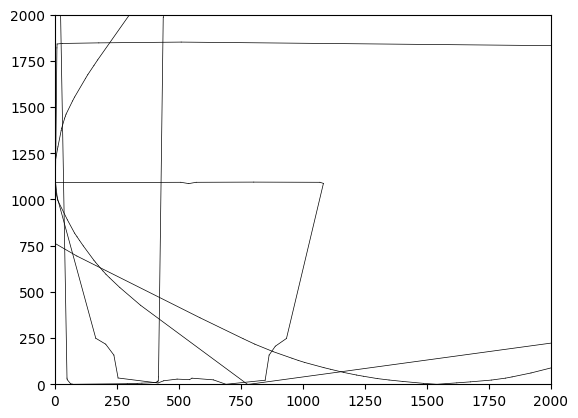

<Figure size 640x480 with 0 Axes>

In [25]:
def place_polygons_at_origin(polys):
    for poly in range(len(polys)):
        # Find the bottom-left corner of each polygon to move it to (0,0)
        left, bottom, _, _ = GeoFunc.checkBoundValue(polys[poly])
        
        # Slide the polygon so that its bottom-left corner is at (0, 0)
        print({
            'left': left,
            'bottom': bottom,
		})
        polys[poly][:] = GeoFunc.getSlide(polys[poly], -left , -bottom)

    # Show the polygons after placement at the origin
    PltFunc.showPolys(polys)

# Place the polygons at (0, 0)
place_polygons_at_origin(polys)


Total Num: 4
############################## Place the  2 th shape #################################
############################## Place the  3 th shape #################################
############################## Place the  4 th shape #################################


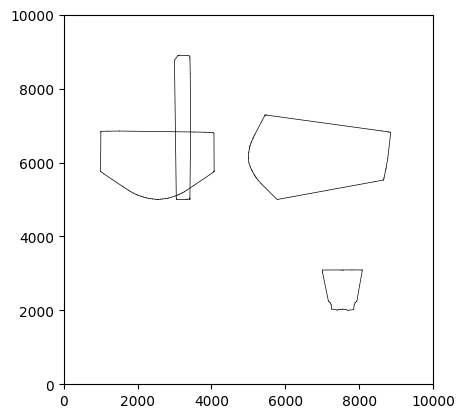

<Figure size 640x480 with 0 Axes>

In [26]:
# Define the canvas size
canvas_width = 10000
canvas_height = 10000

# Example positions for the polygons
positions = [
	(1000, 5000),
	(1000 + 500 * 4, 5000),
	(1000 + 1000 * 4, 5000),
	(1000 + 1500 * 4, 2000)
]
			
# Initialize the class with the custom positions
blf = BottomLeftFill(canvas_width, canvas_height, polys, positions=positions)


# TESTS ==================

In [27]:
class BottomLeftFill(object):
    def __init__(self, width, height, original_polygons, positions=None, **kw):
        self.choose_nfp = False
        self.width = width
        self.height = height  # Set the height of the canvas
        self.length = height  # Set the length of the canvas
        self.contain_length = 2000
        self.polygons = original_polygons
        self.NFPAssistant = None
        if 'NFPAssistant' in kw:
            self.NFPAssistant = kw["NFPAssistant"]
        self.vertical = False
        if 'vertical' in kw:
            self.vertical = kw['vertical']
        
        # Positions array for custom placement
        self.positions = positions  # Array of tuples with (x, y) positions
        
        print("Total Num:", len(original_polygons))
        self.placeFirstPoly()
        for i in range(1, len(self.polygons)):
            print("############################## Place the ", i + 1, "th shape #################################")
            self.placePoly(i)

        self.getLength()
        self.showAll()

    def placeFirstPoly(self):
        poly = self.polygons[0]
        if GeoFunc.is_valid_polygon(poly):
            if self.positions and len(self.positions) > 0:
                # Place the first polygon at the given position from the positions array
                x_pos, y_pos = self.positions[0]
                left_index, bottom_index, _, _ = GeoFunc.checkBound(poly)
                GeoFunc.slidePoly(poly, x_pos - poly[left_index][0], y_pos - poly[bottom_index][1])
            else:
                # Default behavior: Place it at the bottom-left corner
                left_index, bottom_index, _, _ = GeoFunc.checkBound(poly)
                GeoFunc.slidePoly(poly, -poly[left_index][0], -poly[bottom_index][1])
        else:
            print("El primer polígono no es válido. No se puede colocar.")

    def placePoly(self, index):
        adjoin = self.polygons[index]
        if not GeoFunc.is_valid_polygon(adjoin):
            print(f"El polígono {index + 1} no es válido. Se omite.")
            return
        
        if self.positions and index < len(self.positions):
            # Place the polygon at the specified position from the positions array
            x_pos, y_pos = self.positions[index]
            left_index, bottom_index, _, _ = GeoFunc.checkBound(adjoin)
            GeoFunc.slidePoly(adjoin, x_pos - adjoin[left_index][0], y_pos - adjoin[bottom_index][1])
        else:
            # Default Bottom-Left Fill placement logic
            if self.vertical:
                ifr = PackingUtil.getInnerFitRectangle(self.polygons[index], self.width, self.length)
            else:
                ifr = PackingUtil.getInnerFitRectangle(self.polygons[index], self.length, self.width)
            differ_region = Polygon(ifr)

            for main_index in range(0, index):
                main = self.polygons[main_index]
                if self.NFPAssistant is None:
                    nfp = NFP(main, adjoin).nfp
                else:
                    nfp = self.NFPAssistant.getDirectNFP(main, adjoin)

                if len(nfp) < 3:
                    print(f"Skipping invalid NFP calculation due to insufficient points for polygon {index + 1}.")
                    continue

                nfp_poly = Polygon(nfp)
                try:
                    differ_region = differ_region.difference(nfp_poly)
                except Exception as e:
                    print(f'NFP failure for polygon {index + 1}: {str(e)}')
                    self.showAll()
                    for poly in [main, adjoin]:
                        print(f"Polygon area: {Polygon(poly).area}")
                    self.showPolys([main, adjoin, nfp])

            differ = GeoFunc.polyToArr(differ_region)
            if differ:  # Check if 'differ' is not empty
                differ_index = self.getBottomLeft(differ)
                refer_pt_index = GeoFunc.checkTop(adjoin)
                GeoFunc.slideToPoint(self.polygons[index], adjoin[refer_pt_index], differ[differ_index])
            else:
                print(f"Warning: No feasible placement found for polygon {index + 1}")
                # Handle the case where no placement is found, e.g., skip this polygon

    def getBottomLeft(self, poly):
        bl = []  # bottom left of all points
        _min = 999999
        for i, pt in enumerate(poly):
            pt_object = {
                "index": i,
                "x": pt[0],
                "y": pt[1]
            }
            target = pt[1] if self.vertical else pt[0]
            if target < _min:
                _min = target
                bl = [pt_object]
            elif target == _min:
                bl.append(pt_object)
        if len(bl) == 1:
            return bl[0]["index"]
        else:
            target = "x" if self.vertical else "y"
            _min = bl[0][target]
            one_pt = bl[0]
            for pt_index in range(1, len(bl)):
                if bl[pt_index][target] < _min:
                    one_pt = bl[pt_index]
                    _min = one_pt[target]
            return one_pt["index"]

    def showAll(self):
        for i in range(0, len(self.polygons)):
            PltFunc.addPolygon(self.polygons[i])
        length = max(self.width, self.contain_length)
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.gca().set_aspect('equal', adjustable='box')
        PltFunc.showPlt(width=self.width, height=self.height)

    def showPolys(self, polys):
        for i in range(0, len(polys) - 1):
            PltFunc.addPolygon(polys[i])
        PltFunc.addPolygonColor(polys[len(polys) - 1])
        length = max(self.width, self.contain_length)
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.gca().set_aspect('equal', adjustable='box')
        PltFunc.showPlt(width=self.width, height=self.height)

    def getLength(self):
        _max = 0
        for i in range(0, len(self.polygons)):
            extreme_index = GeoFunc.checkTop(self.polygons[i]) if self.vertical else GeoFunc.checkRight(self.polygons[i])
            extreme = self.polygons[i][extreme_index][1] if self.vertical else self.polygons[i][extreme_index][0]
            if extreme > _max:
                _max = extreme
        self.contain_length = _max
        return _max


In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def calculate_bounding_box(poly):
    """
    Calculate the bounding box of a polygon.
    Returns the left, bottom, right, and top boundaries of the polygon.
    """
    left = min(point[0] for point in poly)
    right = max(point[0] for point in poly)
    bottom = min(point[1] for point in poly)
    top = max(point[1] for point in poly)
    return (left, bottom, right, top)

def draw_bounding_box(poly, ax, color='red'):
    """
    Draws a bounding box for a polygon on the provided matplotlib axis.
    """
    left, bottom, right, top = calculate_bounding_box(poly)
    width = right - left
    height = top - bottom

    # Create a rectangle patch (bounding box)
    bbox = patches.Rectangle((left, bottom), width, height, linewidth=1, edgecolor=color, facecolor='none', linestyle='--')
    ax.add_patch(bbox)

def render_polygons_with_bboxes(polygons):
    """
    Render polygons along with their bounding boxes on a matplotlib plot.
    """
    fig, ax = plt.subplots()

    # Render each polygon
    for poly in polygons:
        PltFunc.addPolygon(poly)  # Assuming PltFunc.addPolygon already renders the polygon
        
        # Draw the bounding box for the polygon
        draw_bounding_box(poly, ax, color='red')

    # Set axis limits
    plt.xlim(0, 10000)
    plt.ylim(0, 10000)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Example usage:


In [29]:
def check_overlap(poly1_bounds, poly2_bounds, buffer=50):
    """
    Check if two bounding boxes overlap or are within the buffer distance.
    poly1_bounds and poly2_bounds are in the format (left, bottom, right, top).
    """
    return not (
        poly1_bounds[2] + buffer < poly2_bounds[0] or  # Right of poly1 is left of poly2
        poly1_bounds[0] - buffer > poly2_bounds[2] or  # Left of poly1 is right of poly2
        poly1_bounds[3] + buffer < poly2_bounds[1] or  # Top of poly1 is below poly2
        poly1_bounds[1] - buffer > poly2_bounds[3]     # Bottom of poly1 is above poly2
    )

In [30]:
def find_bottom_left_position(poly, placed_polygons_bounds, canvas_width, canvas_height, buffer=50):
    """
    Find the bottom-left position for the polygon by placing it in the lowest, left-most possible
    position on the canvas, ensuring no overlap with previously placed polygons.
    """
    best_x, best_y = None, None
    min_y = canvas_height

    for x in range(0, canvas_width, 50):  # Incremental x position checks
        for y in range(0, canvas_height, 50):  # Incremental y position checks
            GeoFunc.slidePoly(poly, x, y)  # Slide polygon to the current x, y
            current_bounds = calculate_bounding_box(poly)

            # Check for overlap with all previously placed polygons
            overlaps = any(check_overlap(current_bounds, bounds, buffer) for bounds in placed_polygons_bounds)

            if not overlaps and y < min_y:
                # Update the best position
                best_x, best_y = x, y
                min_y = y

            # Slide back to original position for the next iteration
            GeoFunc.slidePoly(poly, -x, -y)

    if best_x is None and best_y is None:
        return 0, 0  # Default if no position found
    return best_x, best_y


def place_polygons_using_bottom_left(polys, canvas_width, canvas_height, buffer=50):
    """
    Place polygons on the canvas using the bottom-left heuristic to find optimal positions
    and avoid overlap.
    """
    placed_positions = []
    placed_bounds = []

    for poly in polys:
        if not placed_bounds:
            # Place the first polygon at (0, 0)
            GeoFunc.slidePoly(poly, 0, 0)
            current_bounds = calculate_bounding_box(poly)
            x_pos, y_pos = 0, 0  # Initial position
        else:
            # Find the bottom-left non-overlapping position for the current polygon
            x_pos, y_pos = find_bottom_left_position(poly, placed_bounds, canvas_width, canvas_height, buffer)

        # Move the polygon to the new position
        GeoFunc.slidePoly(poly, x_pos, y_pos)

        # Record the position and bounds
        placed_positions.append((x_pos, y_pos))
        placed_bounds.append(calculate_bounding_box(poly))

    return placed_positions

Total Num: 2
############################## Place the  2 th shape #################################


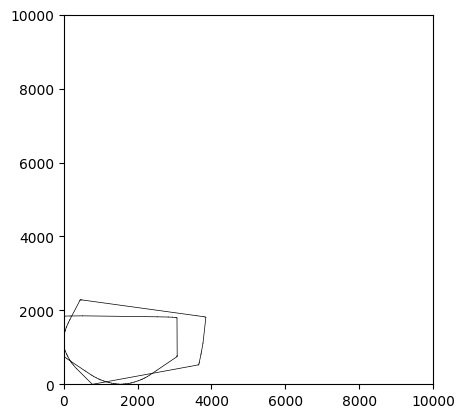

<Figure size 640x480 with 0 Axes>

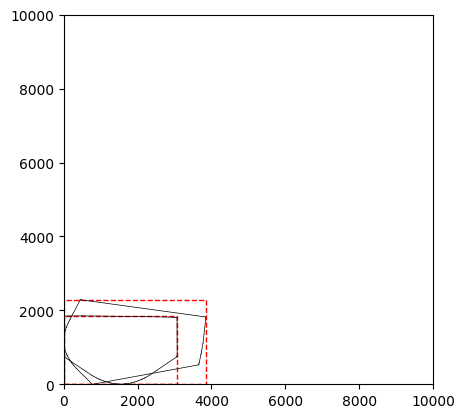

In [31]:


# Example usage:
canvas_width = 10000
canvas_height = 10000

# Using test polygons (replace these with actual polygons)
test_polys = [
    polys[0],
    polys[2]
]

# Place the polygons on the canvas using the Bottom-Left algorithm
positions = place_polygons_using_bottom_left(test_polys, canvas_width, canvas_height, buffer=50)

# Initialize the BottomLeftFill class with the positions
blf = BottomLeftFill(canvas_width, canvas_height, test_polys, positions=[(0, 0), (0, 0), (0, 0)])

# Render the polygons with bounding boxes
render_polygons_with_bboxes(test_polys)


In [54]:
from rectpack import newPacker

def place_polygons_with_rectpack(polys, canvas_width, canvas_height):
    positions = []
    packer = newPacker()

    # Add rectangles (bounding boxes of polygons) to the packer
    for poly in polys:
        left, bottom, right, top = calculate_bounding_box(poly)
        # print({
		# 	"left": left,
		# 	"bottom": bottom,
		# 	"right": right,
		# 	"top": top
		# })
        width = right - left
        height = top - bottom
        print({
			"width": width,
            "height": height,
		})
        packer.add_rect(width, height)

    print(packer)

    # # Define the size of the canvas
    # packer.add_bin(canvas_width, canvas_height)

    # # Start packing
    # packer.pack()

    # for rect in packer.rect_list():
    #     x_pos, y_pos, width, height = rect
    #     positions.append((x_pos, y_pos))

    return positions


In [55]:
place_polygons_with_rectpack(test_polys, canvas_width, canvas_height)


{'width': 3073.0739135742188, 'height': 1851.681884765625}
{'width': 3848.6281204223633, 'height': 2285.76953125}


[]

In [68]:
from rectpack import newPacker

def place_polygons_with_rectpack(polys, canvas_width, canvas_height):
    """
    Use the RectPack library to place polygons using their bounding boxes in bins.
    """
    packer = newPacker()

    # Add rectangles (bounding boxes of polygons) to the packer
    for poly in polys:
        left, bottom, right, top = calculate_bounding_box(poly)
        width = right - left
        height = top - bottom
        packer.add_rect(width, height)

    # Define the canvas as a bin where rectangles will be packed
    packer.add_bin(canvas_width, canvas_height)

    # Start packing
    packer.pack()

    positions = []
    
    # Loop over bins and packed rectangles to get the position of each polygon
    for abin in packer:
        print(f"Bin ID: {abin.bid}, Size: ({abin.width}, {abin.height})")
        for rect in abin:
            # Rect is a Rectangle object; we extract its position and size
            x_pos = rect.x
            y_pos = rect.y
            w = rect.width
            h = rect.height
            print(f"Rectangle at x: {x_pos}, y: {y_pos}, width: {w}, height: {h}")
            
            # We only need x and y for placing polygons
            positions.append((x_pos, y_pos))

    return positions



Bin ID: None, Size: (10000, 10000)
Rectangle at x: 0, y: 0, width: 3073.0739135742188, height: 1851.681884765625
Total Num: 1


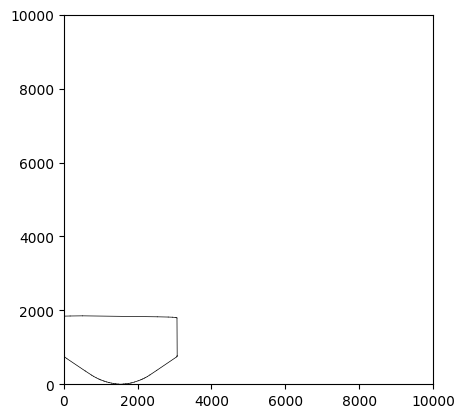

<Figure size 640x480 with 0 Axes>

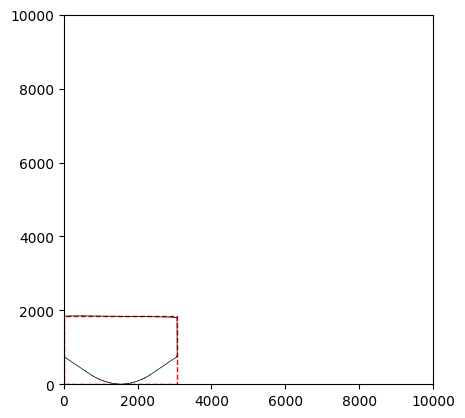

In [74]:
# Example usage:
canvas_width = 10000
canvas_height = 10000

# Using test polygons (replace these with actual polygons)
test_polys = [
    polys[0],
    # polys[1],
    # polys[2],
]

# Place the polygons on the canvas using RectPack
positions = place_polygons_with_rectpack(test_polys, canvas_width, canvas_height)

# positions

# Initialize the BottomLeftFill class with the positions
blf = BottomLeftFill(canvas_width, canvas_height, test_polys, positions=[(0,0)])

# Render the polygons with bounding boxes
render_polygons_with_bboxes(test_polys)

In [194]:
from rectpack import newPacker

def place_polygons_without_rotation(polys, canvas_width, canvas_height):
    """
    Use RectPack to place polygons using their bounding boxes without rotation.
    """
    sizes = []
    packer = newPacker(rotation=False)  # Disable rotation in RectPack

    # Add rectangles (bounding boxes of polygons) to the packer
    for poly in polys:
        left, bottom, right, top = calculate_bounding_box(poly)
        width = right - left
        height = top - bottom
        sizes.append((width, height))
        packer.add_rect(width, height)

    # Define the canvas as a bin where rectangles will be packed
    packer.add_bin(canvas_width, canvas_height)

    # Start packing
    packer.pack()

    positions = []
    
    # Loop over bins and packed rectangles to get the position of each polygon
    for abin in packer:
        for rect in abin:
            # Rect is a Rectangle object; we extract its position and size
            x_pos = rect.x
            y_pos = rect.y
            w = rect.width
            h = rect.height
            positions.append((x_pos, y_pos))

    return positions, sizes

Total Num: 4
############################## Place the  2 th shape #################################
############################## Place the  3 th shape #################################
############################## Place the  4 th shape #################################


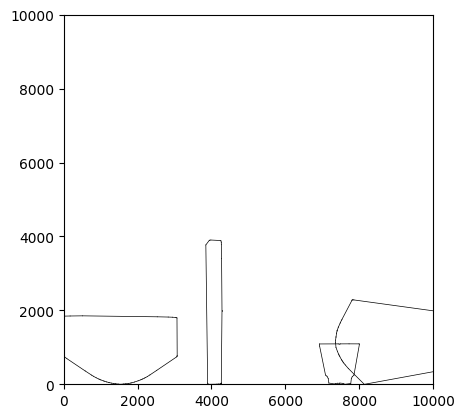

<Figure size 640x480 with 0 Axes>

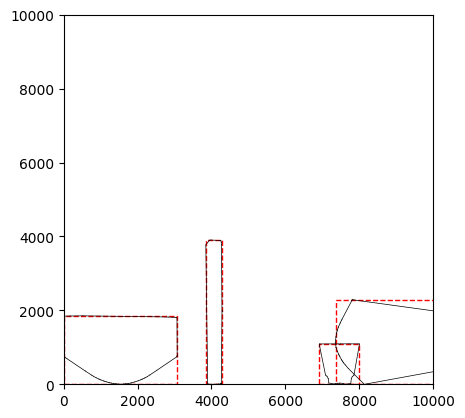

In [192]:
# Example usage:
canvas_width = 10000
canvas_height = 10000

# Using test polygons (replace these with actual polygons)
test_polys = [
    polys[0],
    polys[1],
    polys[3],
    polys[2]
]

# Place the polygons on the canvas without rotation
positions, _ = place_polygons_without_rotation(test_polys, canvas_width, canvas_height)

# Adjust polygon positions based on bounding boxes
for i, poly in enumerate(test_polys):
    x_pos, y_pos = positions[i]
    
    # Calculate current bounding box of the polygon
    left, bottom, right, top = calculate_bounding_box(poly)
    
    # Move the polygon to the new position by adjusting its bottom-left corner
    shift_x = x_pos - left
    shift_y = y_pos - bottom
    GeoFunc.slidePoly(poly, shift_x, shift_y)

# Initialize the BottomLeftFill class with the adjusted positions (if needed)
blf = BottomLeftFill(canvas_width, canvas_height, test_polys, positions=positions)

# Render the polygons with bounding boxes
render_polygons_with_bboxes(test_polys)


# EJEMPLOOOOOOO

In [196]:
positions, sizes = place_polygons_without_rotation(test_polys, canvas_width, canvas_height)
sizes

[(3073.0739135742188, 1851.681884765625),
 (437.0, 3903.0),
 (1083.0, 1094.0),
 (3848.6281204223633, 2285.76953125)]

In [197]:
from rectpack import newPacker



# rectangles = [
#     (3073.0739135742188, 1851.681884765625),
# 	(437.0, 3903.0),
# 	(3848.6281204223633, 2285.76953125),
# ]
bins = [(10000, 10000)]

packer = newPacker(rotation=False)

# Add the rectangles to packing queue
for r in sizes:
	packer.add_rect(*r)

# Add the bins where the rectangles will be placed
for b in bins:
	packer.add_bin(*b)

# Start packing
packer.pack()

In [198]:
# Obtain number of bins used for packing
nbins = len(packer)

# Index first bin
abin = packer[0]

# Bin dimmensions (bins can be reordered during packing)
width, height = abin.width, abin.height

# Number of rectangles packed into first bin
nrect = len(packer[0])


rect = packer[0][0]

# rect is a Rectangle object
x = rect.x # rectangle bottom-left x coordinate
y = rect.y # rectangle bottom-left y coordinate
w = rect.width
h = rect.height

In [199]:
recs = []

for abin in packer:
  print(abin.bid) # Bin id if it has one
  for rect in abin:
    print(rect)
    recs.append((rect.x, rect.y, rect.width, rect.height))

None
R(0, 0, 3848.6281204223633, 2285.76953125)
R(3848.6281204223633, 0, 3073.0739135742188, 1851.681884765625)
R(6921.702033996582, 0, 437.0, 3903.0)
R(7358.702033996582, 0, 1083.0, 1094.0)


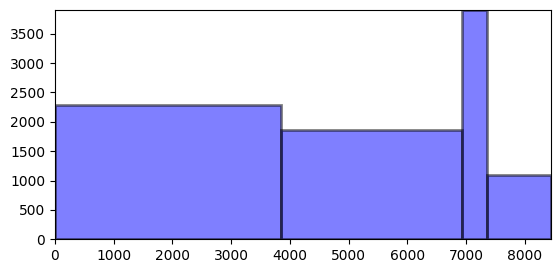

In [201]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_rectangles(rectangles, color='none'):
    """
    Plots a list of rectangles with the same fill color.
    
    Parameters:
    rectangles (list of tuples): Each tuple contains 4 elements representing the coordinates and size of a rectangle (x, y, width, height).
    color (str): The fill color for all rectangles.
    """
    fig, ax = plt.subplots()
    
    for rect in rectangles:
        # Unpack the rectangle coordinates and size
        x, y, width, height = rect
        
        # Create a rectangle patch
        rect_patch = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='black', facecolor=color, alpha=0.5)
        
        # Add the rectangle patch to the plot
        ax.add_patch(rect_patch)
    
    # Set the limits of the plot
    ax.set_xlim(0, max(x + width for x, y, width, height in rectangles))
    ax.set_ylim(0, max(y + height for x, y, width, height in rectangles))
    
    # Display the plot
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Example usage

plot_rectangles(recs, color='blue')

In [216]:
def sort_polygons_by_bounding_box_area(polygons):
    """
    Sort polygons by their bounding box area (width * height).
    """
    def bounding_box_area(poly):
        left, bottom, right, top = calculate_bounding_box(poly)
        return (right - left) * (top - bottom)

    return sorted(polygons, key=bounding_box_area, reverse=True)

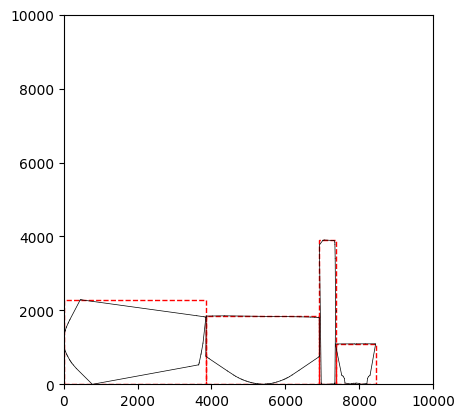

In [225]:
from rectpack import newPacker
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def calculate_bounding_box(poly):
    """
    Calculate the bounding box of a polygon.
    Returns the left, bottom, right, and top boundaries of the polygon.
    """
    left = min(point[0] for point in poly)
    right = max(point[0] for point in poly)
    bottom = min(point[1] for point in poly)
    top = max(point[1] for point in poly)
    return (left, bottom, right, top)

def draw_bounding_box(poly, ax, color='red'):
    """
    Draws a bounding box for a polygon on the provided matplotlib axis.
    """
    left, bottom, right, top = calculate_bounding_box(poly)
    width = right - left
    height = top - bottom

    # Create a rectangle patch (bounding box)
    bbox = patches.Rectangle((left, bottom), width, height, linewidth=1, edgecolor=color, facecolor='none', linestyle='--')
    ax.add_patch(bbox)

def render_polygons_with_bboxes(polygons):
    """
    Render polygons along with their bounding boxes on a matplotlib plot.
    """
    fig, ax = plt.subplots()

    # Render each polygon
    for poly in polygons:
        PltFunc.addPolygon(poly)  # Assuming PltFunc.addPolygon already renders the polygon
        
        # Draw the bounding box for the polygon
        draw_bounding_box(poly, ax, color='red')

    # Set axis limits
    plt.xlim(0, 10000)
    plt.ylim(0, 10000)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def pack_bounding_boxes_with_rectpack(polys, canvas_width, canvas_height):
    """
    Use rectpack to pack bounding boxes of polygons onto the canvas.
    """
    packer = newPacker(rotation=False)  # Disable rotation in rectpack

    # Add bounding boxes of polygons to the packer
    bounding_boxes = []
    for poly in polys:
        left, bottom, right, top = calculate_bounding_box(poly)
        width = right - left
        height = top - bottom
        bounding_boxes.append((width, height))
        packer.add_rect(width, height)

    # Define the canvas as a bin (control canvas size here)
    packer.add_bin(canvas_width, canvas_height)

    # Start packing
    packer.pack()

    # Collect new positions for the bounding boxes
    positions = []
    for abin in packer:
        for rect in abin:
            x_pos = rect.x
            y_pos = rect.y
            positions.append((x_pos, y_pos, rect.width, rect.height))

    return positions

def apply_positions_to_polygons(polys, positions):
    """
    Apply the calculated bounding box positions to move the polygons.
    """
    for i, poly in enumerate(polys):
        x_pos, y_pos, width, height = positions[i]
        
        # Calculate current bounding box of the polygon
        left, bottom, right, top = calculate_bounding_box(poly)
        
        # Move the polygon to the new position by adjusting its bottom-left corner
        shift_x = x_pos - left
        shift_y = y_pos - bottom
        GeoFunc.slidePoly(poly, shift_x, shift_y)

# Example usage:
canvas_width = 10000
canvas_height = 10000

# Using test polygons (replace these with actual polygons)
test_polys = [
    polys[1],
    polys[2],
    polys[3],
    polys[0],
]

sorted_polys = sort_polygons_by_bounding_box_area(test_polys)

# Use RectPack to get new positions for the bounding boxes of the polygons
positions = pack_bounding_boxes_with_rectpack(sorted_polys, canvas_width, canvas_height)

# Apply the new positions to the polygons
apply_positions_to_polygons(sorted_polys, positions)

# Render the polygons with bounding boxes
render_polygons_with_bboxes(sorted_polys)
